In [64]:
import json
import pandas as pd
import os
from vega import VegaLite
%run table_utils

pd.set_option('display.max_rows', 10)
#pd.set_option('display.max_columns', 10)

benchmark_dir = "../benchmarks"

def load_input_table(fname):
    with open(os.path.join(benchmark_dir, fname), "r") as f:
        benchmark = json.load(f)
        input_data = benchmark["input_data"]
        df = pd.DataFrame.from_records(input_data)
        #df = load_and_clean_table(df, return_as_df=True)
        return df

def wrap_vl_json(spec, df):
    data = df.to_json(orient='records')
    spec["data"] = {"values": json.loads(data)}
    return spec

,Actual Profits,Number of Units,Quarter
0,3358,23,Quarter1
1,3829,27,Quarter2
2,2374,15,Quarter3
3,3373,43,Quarter4


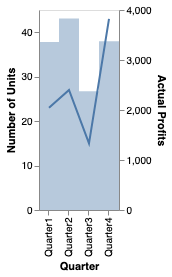

In [65]:
df1 = load_input_table("001.json")
#df = pd.melt(df, id_vars='Quarter', value_vars=["Actual Profits", "No. of Units"])

display(df1)

chart = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": {"type": "line"},
            "encoding": {
                "y": {"field": "Number of Units", "type": "quantitative"},
                "x": { "field": "Quarter", "type": "nominal" }
            }
        }, 
        {
            "mark": {"opacity": 0.4, "type": "bar"},
            "encoding": {
                "y": {"type": "quantitative", "field": "Actual Profits"},
                "x": { "field": "Quarter", "type": "nominal" }
            }
        }
  ],
  "resolve": {"scale": {"y": "independent"}}
}

VegaLite(chart, df1)

,Month,variable,value
0,Apr-15,Low (<50%},50.0
1,May-15,Low (<50%},50.0
2,Jun-15,Low (<50%},50.0
3,Jul-15,Low (<50%},50.0
4,Aug-15,Low (<50%},50.0
...,...,...,...
55,Nov-15,West,88.3
56,Dec-15,West,75.5
57,Jan-16,West,72.1
58,Feb-16,West,93.1


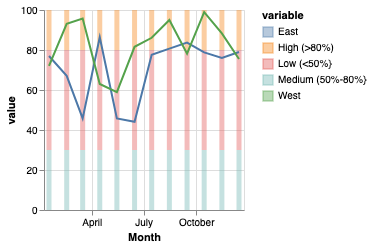

In [66]:
df2 = load_input_table("002.json")

df2 = pd.melt(df2, id_vars='Month', value_vars=["Low (<50%}", "Medium (50%-80%}", "High (>80%)", "East", "West"])

display(df2)
#print(df2.to_json(orient="records"))

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": {"opacity": 0.4, "type": "bar"},
            "transform": [{"filter": "datum.variable != \"East\" && datum.variable != \"West\""}],
            "encoding": {
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"},
                "x": { "field": "Month", "type": "temporal" }
            }
        }, 
        {
            "mark": {"type": "line", "stroke": "red"},
            "transform": [{"filter": "datum.variable == \"East\" || datum.variable == \"West\""}],
            "encoding": {
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"},
                "x": { "field": "Month", "type": "temporal" }
            }
        }
  ]
}

#print(json.dumps(vl_spec, indent=4))

VegaLite(vl_spec, df2)

,Month,Net Cash Flow,Net Cash Flow Sum,c,d
0,Start,80000,80000,0,False
1,Apr,-5003,74997,80000,True
2,May,-16700,58297,74997,True
3,Jun,48802,107099,58297,False
4,Jul,-11198,95901,107099,True
...,...,...,...,...,...
8,Nov,43250,98271,55021,False
9,Dec,-18280,79991,98271,True
10,Jan,26670,106661,79991,False
11,Feb,15000,121661,106661,False


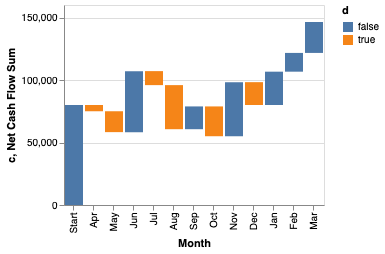

In [67]:
df3 = load_input_table("003.json")

df3_1 = df3["Net Cash Flow"].cumsum()
df3 = df3.join(df3_1, lsuffix='', rsuffix=' Sum')
df3 = df3.assign(c=df3["Net Cash Flow Sum"]-df3["Net Cash Flow"])
df3 = df3.assign(d=df3["c"]>df3["Net Cash Flow Sum"])

display(df3)

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": {"field": "Month", "type": "nominal", "sort": "none"},
        "y2": {
          "field": "Net Cash Flow Sum",
          "type": "quantitative"    
        },
        "y": {"field": "c", "type": "quantitative"},
        "color": {"field": "d", "type": "nominal"},
    }
}

VegaLite(vl_spec, df3)

,Age Group,variable,value,gender,year
0,00-04,Female-1986,8243,Female,1986
1,05-09,Female-1986,8440,Female,1986
2,10-14,Female-1986,8659,Female,1986
3,15-19,Female-1986,8588,Female,1986
4,20-24,Female-1986,7930,Female,1986
...,...,...,...,...,...
63,60-64,Male-2050,7315,Male,2050
64,65-69,Male-2050,6712,Male,2050
65,70-74,Male-2050,5621,Male,2050
66,75-79,Male-2050,4176,Male,2050


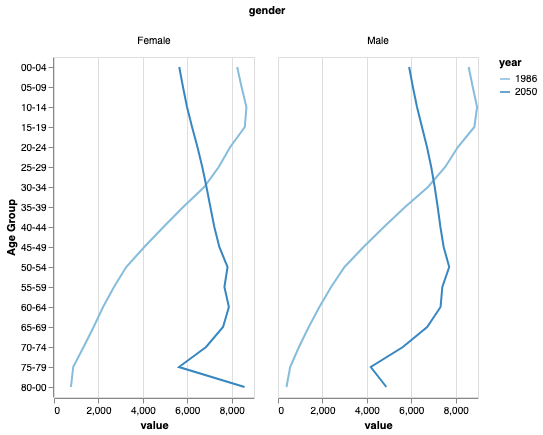

In [68]:
df4 = load_input_table("004.json")

df4 = pd.melt(df4, id_vars='Age Group', value_vars=["Female-1986", "Female-2050", "Male-1986", "Male-2050"])

split_col = df4["variable"].str.split("-", expand=True)
df4["gender"] = split_col[0]
df4["year"] = split_col[1]

display(df4)

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "y": {"field": "Age Group", "type": "nominal", "sort": None},
        "x": {
          "field": "value",
          "type": "quantitative"    
        },
        "column": {"field": "gender", "type": "nominal"},
        "color": {"field": "year","type": "ordinal"}
    }
}

VegaLite(vl_spec, df4)

,Month,variable,value
0,Jan,Cost,6.0
1,Feb,Cost,15.0
2,Mar,Cost,24.0
3,Apr,Cost,33.0
4,May,Cost,42.0
...,...,...,...
19,Feb,Sales,20.0
20,Mar,Sales,30.0
21,Apr,Sales,40.0
22,May,Sales,50.0


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": {
                "type": "bar"
            },
            "transform": [
                {
                    "filter": "datum.variable != \"ROI\""
                }
            ],
            "encoding": {
                "x": {
                    "field": "Month",
                    "type": "nominal"
                },
                "color": {
                    "field": "variable",
                    "type": "nominal"
                },
                "y": {
                    "field": "value",
                    "type": "quantitative"
                }
            }
        },
        {
            "mark": {
                "type": "line",
                "stroke": "red"
            },
            "transform": [
                {
                    "filter": "datum.variable == \"ROI\""
                }
            ],
            "encoding": {
               

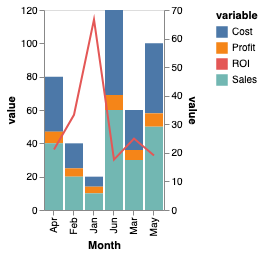

In [69]:
df5 = load_input_table("005.json")

df5 = pd.melt(df5, id_vars='Month', value_vars=["Cost", "Profit", "ROI", "Sales"])

display(df5)
#print(df5.to_json(orient="records"))

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": {"type": "bar"},
            "transform": [{"filter": "datum.variable != \"ROI\""}],
            "encoding": {
                "x": { "field": "Month", "type": "nominal" },
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"}
            }
        },
        {
            "mark": {"type": "line", "stroke": "red"},
            "transform": [{"filter": "datum.variable == \"ROI\""}],
            "encoding": {
                "x": { "field": "Month", "type": "nominal" },
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"}
            }
        }
  ],
  "resolve": {"scale": {"y": "independent"}}
}

print(json.dumps(vl_spec, indent=4))

VegaLite(vl_spec, df5)

,Bucket,variable,value
0,Bucket E,Actual,115
1,Bucket D,Actual,90
2,Bucket C,Actual,115
3,Bucket B,Actual,140
4,Bucket A,Actual,150
5,Bucket E,Budgeted,100
6,Bucket D,Budgeted,100
7,Bucket C,Budgeted,125
8,Bucket B,Budgeted,125
9,Bucket A,Budgeted,140


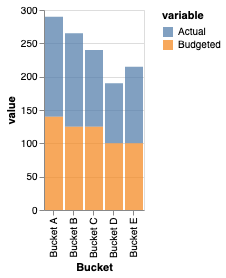

In [70]:
df6 = load_input_table("006.json")

df6 = pd.melt(df6, id_vars='Bucket', value_vars=["Actual", "Budgeted"])

display(df6)
#print(df6.to_json(orient="records"))

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {"type": "bar", "opacity":0.7},
    "encoding": {
        "color": {"field": "variable", "type": "nominal"},
        "y": {"field": "value", "type": "quantitative"},
        "x": { "field": "Bucket", "type": "nominal" },
    }
}

VegaLite(vl_spec, df6)

,id,variable,value
0,0,Strongly Disagree,7.0
1,1,Strongly Disagree,10.0
2,2,Strongly Disagree,10.0
3,0,Agree,35.0
4,1,Agree,10.0
...,...,...,...
7,1,Disagree,10.0
8,2,Disagree,15.0
9,0,Strongly Agree,50.0
10,1,Strongly Agree,70.0


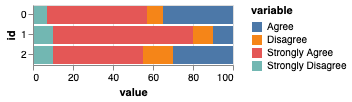

In [71]:
df7 = load_input_table("007.json")

df7['id'] = df7.index
df7 = pd.melt(df7, id_vars='id', value_vars=["Strongly Disagree", "Agree", "Disagree", "Strongly Agree"])

display(df7)
#print(json.dumps(df7.to_dict(orient="records")))

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {"type": "bar"},
    "encoding": {
        "color": {"field": "variable", "type": "nominal"},
        "y": {"field": "id", "type": "nominal"},
        "x": { "field": "value", "type": "quantitative"}    
    }
}

VegaLite(vl_spec, df7)

Value,variable,lower range,means,stddev,upper range
0,Y1,0.39,0.52,0.1328,0.66
1,Y2,0.44,0.57,0.1321,0.70
2,Y3,0.47,0.60,0.1303,0.73
3,Y4,0.50,0.63,0.1266,0.75
4,Y5,0.51,0.63,0.1225,0.75


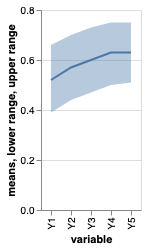

In [72]:
df8 = load_input_table("008.json")

# gather(dat, "col1", "col2", -Value) %>% spread(Value, col2)
df8 = pd.melt(df8, id_vars='Value', value_vars=["Y1", "Y2", "Y3", "Y4", "Y5"])
df8 = df8.pivot(index='variable',columns='Value', values='value').reset_index()

display(df8)
#print(json.dumps(df8.to_dict(orient="records")))


vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": "line",
            "encoding": {
                "x": { "field": "variable", "type": "nominal" },
                "y": {"field": "means", "type": "quantitative"}
            }
        }, 
        {
            "mark": {"opacity": 0.4, "type": "area"},
            "encoding": {
                "x": { "field": "variable", "type": "nominal" },
                "y": {"type": "quantitative", "field": "lower range"},
                "y2": {"type": "quantitative", "field": "upper range"}
            }
        }
  ]
}

VegaLite(vl_spec, df8)

Rae,Location,variable,American Indian or Alaska Native,Asian,Black or African American,Hispanic or Latino,Native Hawaiian or Pacific Islander,Other Race,Two or more races,White,"White,not Hispanic or Latino"
0,Arizona,2009,30.6,15.0,15.9,27.9,25.5,23.7,14.3,16.3,11.1
1,Arizona,2010,30.8,12.1,15.3,27.4,11.9,27.1,14.7,15.6,10.9
2,Arizona,2011,27.5,15.1,18.2,27.8,30.2,28.4,18.2,15.7,10.9
3,Arizona,2012,29.3,16.2,16.2,28.3,16.6,31.0,16.5,16.0,11.3
4,Arizona,2013,26.9,15.1,17.4,27.5,21.3,30.1,15.2,15.7,11.2
...,...,...,...,...,...,...,...,...,...,...,...
13,United States,2010,29.2,15.7,18.2,30.9,17.4,34.6,14.9,13.7,10.9
14,United States,2011,27.6,15.4,17.7,29.8,18.5,33.6,14.4,13.4,10.7
15,United States,2012,27.4,15.0,17.3,29.0,18.0,32.3,14.0,13.1,10.4
16,United States,2013,26.9,14.6,17.1,28.4,17.9,31.7,13.2,12.9,10.2


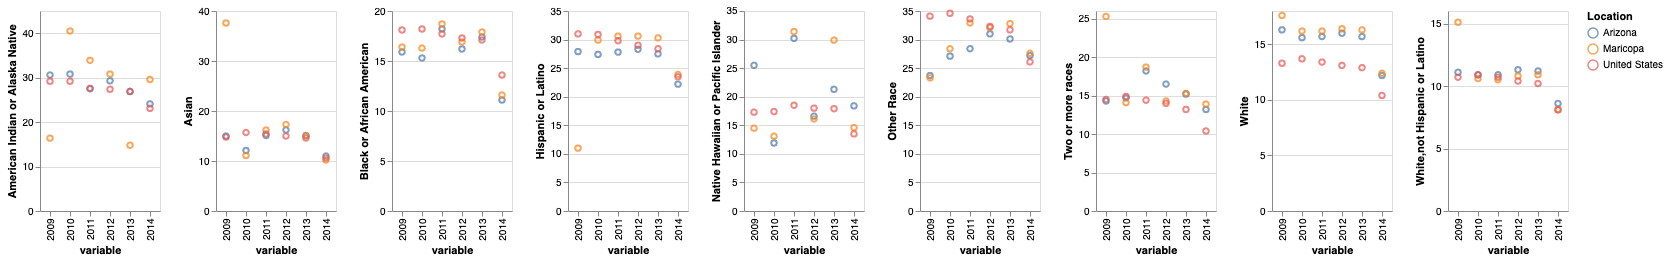

In [73]:
df9 = load_input_table("009.json")
df9 = pd.melt(df9, id_vars=['Location', 'Rae'], value_vars=["2009", "2010", "2011", "2012", "2013", "2014"])
df9 = df9.pivot_table(index=["Location", "variable"], columns='Rae', values='value').reset_index()

display(df9)
#print(json.dumps(df9.to_dict(orient="records")))


VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "repeat": ["American Indian or Alaska Native", "Asian", "Black or African American", 
               "Hispanic or Latino", "Native Hawaiian or Pacific Islander", "Other Race",
               "Two or more races", "White", "White,not Hispanic or Latino"],
    "columns": 10,
  "spec": {
    "encoding": {
        "x": { "field": "variable", "type": "nominal" }
    },
    "layer": [
        {
            "mark": "point",
            "encoding": {
                "y": {"field": {"repeat": "repeat"}, "type": "quantitative"},
                "color": {"field": "Location", "type": "nominal"}
            }
        }
    ]
  }
}, df9)

,Location,Rae,variable,value
0,United States,White,2009,13.3
1,United States,Black or African American,2009,18.1
2,United States,American Indian or Alaska Native,2009,29.2
3,United States,Asian,2009,14.8
4,United States,Native Hawaiian or Pacific Islander,2009,17.3
...,...,...,...,...
157,Maricopa,Native Hawaiian or Pacific Islander,2014,14.6
158,Maricopa,Other Race,2014,27.6
159,Maricopa,Two or more races,2014,13.9
160,Maricopa,"White,not Hispanic or Latino",2014,8.1


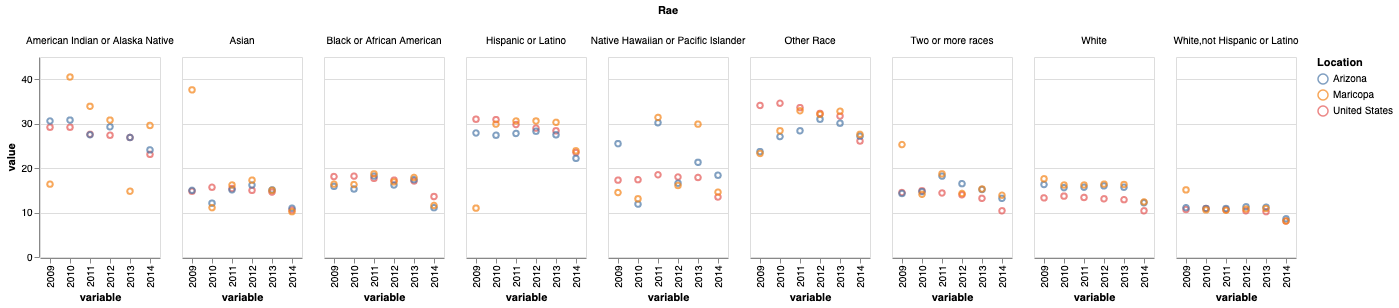

In [74]:
df9 = load_input_table("009.json")
df9 = pd.melt(df9, id_vars=['Location', 'Rae'], value_vars=["2009", "2010", "2011", "2012", "2013", "2014"])

display(df9)
#print(json.dumps(df9.to_dict(orient="records")))

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "point",
    "encoding": {
        "x": { "field": "variable", "type": "nominal" },
        "y": {"field": "value", "type": "quantitative"},
        "color": {"field": "Location", "type": "nominal"},
        "column": {"field": "Rae", "type": "nominal"}
    }
}

VegaLite(vl_spec, df9)

,Class,variable,value
0,Literacy,Fall,34
1,Language,Fall,63
2,Math,Fall,67
3,Science,Fall,92
4,Arts,Fall,96
5,Literacy,Spring,69
6,Language,Spring,77
7,Math,Spring,75
8,Science,Spring,98
9,Arts,Spring,100


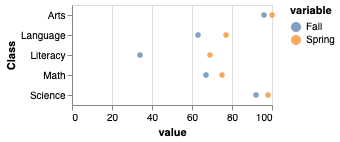

In [75]:
df10 = load_input_table("010.json")
df10 = pd.melt(df10, id_vars="Class", value_vars=['Fall', 'Spring'])

display(df10)

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "circle",
    "encoding": {
        "y": {"field": "Class", "type": "nominal"},
        "x": { "field": "value", "type": "quantitative" },
        "color": {"field": "variable", "type": "nominal"}
    }

}

VegaLite(vl_spec, df10)

,C1,C2,variable,value
0,Q1,Targeted,EMEA,66
1,Q1,Engaged,EMEA,65
2,Q1,Pitched,EMEA,59
3,Q1,Adopted,EMEA,52
4,Q2,Targeted,EMEA,56
...,...,...,...,...
43,Q2,Adopted,APAC,27
44,Q3,Targeted,APAC,87
45,Q3,Engaged,APAC,75
46,Q3,Pitched,APAC,74


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "y": {
            "field": "value",
            "type": "quantitative"
        },
        "x": {
            "field": "C2",
            "type": "nominal"
        },
        "column": {
            "field": "variable",
            "type": "nominal"
        },
        "row": {
            "field": "C1",
            "type": "nominal"
        }
    }
}


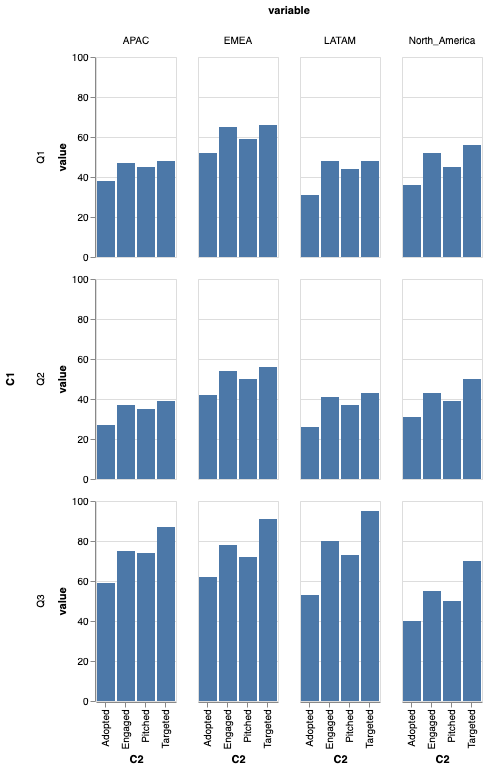

In [76]:
df11 = load_input_table("011.json")
df11 = pd.melt(df11, id_vars=["C1", "C2"], value_vars=["EMEA", "LATAM", "North_America", "APAC"])

display(df11)
#print(json.dumps(df11.to_dict(orient="records")))

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "y": {"field": "value", "type": "quantitative"},
        "x": { "field": "C2", "type": "nominal" },
        "column": {"field": "variable", "type": "nominal"},
        "row": {"field": "C1", "type": "nominal"}
    }
}

print(json.dumps(vl_spec, indent=4))

VegaLite(vl_spec, df11)

,C1,C2,variable,value
0,Q1,Targeted,EMEA,66.0
1,Q1,Engaged,EMEA,65.0
2,Q1,Pitched,EMEA,59.0
3,Q1,Adopted,EMEA,52.0
4,Q2,Targeted,EMEA,56.0
...,...,...,...,...
43,Q2,Adopted,APAC,27.0
44,Q3,Targeted,APAC,87.0
45,Q3,Engaged,APAC,75.0
46,Q3,Pitched,APAC,74.0


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "y": {
            "field": "value",
            "type": "quantitative"
        },
        "x": {
            "field": "C2",
            "type": "nominal"
        },
        "column": {
            "field": "variable",
            "type": "nominal"
        },
        "color": {
            "field": "C1",
            "type": "nominal"
        }
    }
}


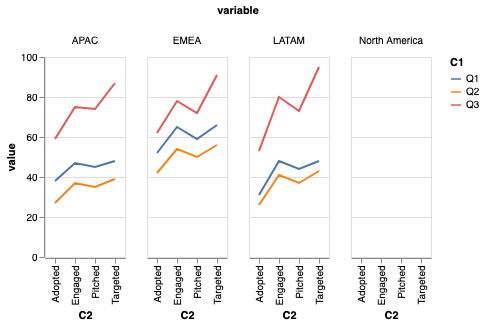

In [78]:
df12 = load_input_table("012.json")
df12 = pd.melt(df12, id_vars=["C1", "C2"], value_vars=["EMEA", "LATAM", "North America", "APAC"])
df12.reindex()

display(df12)
#print(json.dumps(df12.to_dict(orient="records")))

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "y": {"field": "value", "type": "quantitative"},
        "x": { "field": "C2", "type": "nominal" },
        "column": {"field": "variable", "type": "nominal"},
        "color": {"field": "C1", "type": "nominal"}
    }
}

print(json.dumps(vl_spec, indent=4))

VegaLite(vl_spec, df12)

#print(json.dumps(wrap_vl_json(vl_spec, df12)))

,Totals,Value,variable,value,cumsum
0,7,A,alpha,2,2
1,8,B,alpha,2,2
2,9,C,alpha,3,3
3,9,D,alpha,3,3
4,9,E,alpha,4,4
...,...,...,...,...,...
10,7,A,gamma,3,7
11,8,B,gamma,3,8
12,9,C,gamma,3,9
13,9,D,gamma,2,9


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": "bar",
            "encoding": {
                "x": {
                    "field": "Value",
                    "type": "nominal"
                },
                "y": {
                    "field": "value",
                    "type": "quantitative"
                },
                "color": {
                    "field": "variable",
                    "type": "nominal"
                },
                "order": {
                    "field": "variable",
                    "type": "quantitative",
                    "sort": "ascending"
                }
            }
        },
        {
            "mark": "point",
            "encoding": {
                "x": {
                    "field": "Value",
                    "type": "nominal"
                },
                "y": {
                    "field": "cumsum",
                    "type": "quantitative"
     

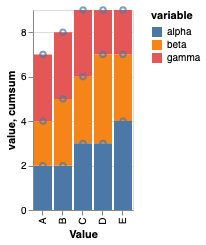

In [79]:
df13 = load_input_table("013.json")

df13 = pd.melt(df13, id_vars=["Totals", "Value"], value_vars=["alpha", "beta", "gamma"])
df13['cumsum'] = df13.groupby("Value")['value'].transform(pd.Series.cumsum)

display(df13)

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [{
        "mark": "bar",
        "encoding": {
            "x": { "field": "Value", "type": "nominal" },
            "y": { "field": "value", "type": "quantitative"},
            "color": {"field": "variable", "type": "nominal"},
            "order": {"field": "variable", "type": "quantitative", "sort": "ascending"}
        }
    },  {
      "mark": "point",
      "encoding": {
        "x": { "field": "Value", "type": "nominal" },
        "y": { "field": "cumsum", "type": "quantitative"},
        "text": {"field": "value", "type": "quantitative"}
      }
    }]
}

print(json.dumps(vl_spec, indent=4))

VegaLite(vl_spec, df13)

,Duration,End of Shift,Period,Shift,Start of Shift,s1,s0
0,60,110 / 1090,1,1,50 / 1150,110,50
1,48,272 / 928,1,2,224 / 976,272,224
2,40,419 / 781,1,3,379 / 821,419,379
3,56,601 / 599,1,4,545 / 655,601,545
4,81,840 / 360,1,5,759 / 441,840,759
...,...,...,...,...,...,...,...
15,51,376 / 824,3,16,325 / 875,376,325
16,23,564 / 636,3,17,541 / 659,564,541
17,10,694 / 506,3,18,684 / 516,694,684
18,80,775 / 425,3,19,695 / 505,775,695


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": {
            "field": "s0",
            "type": "quantitative"
        },
        "x2": {
            "field": "s1",
            "type": "quantitative"
        },
        "y": {
            "field": "Shift",
            "type": "nominal"
        }
    }
}


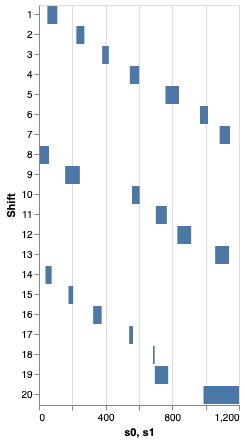

In [80]:
df14 = load_input_table("014.json")

split_col = df14["End of Shift"].str.split("/", expand=True)
df14["s1"] = split_col[0]
split_col = df14["Start of Shift"].str.split("/", expand=True)
df14["s0"] = split_col[0]

display(df14)
#print(json.dumps(df14.to_dict(orient="records")))

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "s0", "type": "quantitative"},
        "x2": { "field": "s1", "type": "quantitative"},
        "y": { "field": "Shift", "type": "nominal"}
    }
}

print(json.dumps(vl_spec, indent=4))

VegaLite(vl_spec, df14)

,Duration,End of Shift,Period,Shift,Start of Shift,s1,s0
0,60,110 / 1090,1,1,50 / 1150,110,50
1,48,272 / 928,1,2,224 / 976,272,224
2,40,419 / 781,1,3,379 / 821,419,379
3,56,601 / 599,1,4,545 / 655,601,545
4,81,840 / 360,1,5,759 / 441,840,759
...,...,...,...,...,...,...,...
15,51,376 / 824,3,16,325 / 875,376,325
16,23,564 / 636,3,17,541 / 659,564,541
17,10,694 / 506,3,18,684 / 516,694,684
18,80,775 / 425,3,19,695 / 505,775,695


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "rect",
    "encoding": {
        "y": {
            "field": "s0",
            "type": "quantitative"
        },
        "x": {
            "field": "Period",
            "type": "nominal"
        },
        "y2": {
            "field": "s1",
            "type": "quantitative"
        }
    }
}


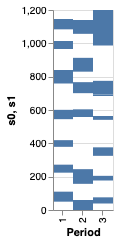

In [81]:
df15 = load_input_table("015.json")

split_col = df15["End of Shift"].str.split("/", expand=True)
df15["s1"] = split_col[0]
split_col = df15["Start of Shift"].str.split("/", expand=True)
df15["s0"] = split_col[0]

display(df15)
#print(json.dumps(df15.to_dict(orient="records")))

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "rect",
    "encoding": {
        "y": { "field": "s0", "type": "quantitative"},
        "x": { "field": "Period", "type": "nominal"},
        "y2": { "field": "s1", "type": "quantitative"},
    }
}

print(json.dumps(vl_spec, indent=4))

VegaLite(vl_spec, df15)

,Amount,Revenue,Variance,Variance %,Year,Year Label,c
0,773000,$773K,39000,+5%,2011,2011,77300039000
1,812000,$812K,-445000,-55%,2012,2012,812000 -445000
2,367000,$367K,117000,+32%,2013,2013,367000117000
3,484000,$484K,278000,+57%,2014,2014,484000278000
4,762000,$762K,-201000,-26%,2015,2015,762000 -201000
5,561000,$561K,213000,+38%,2016,2016,561000213000
6,774000,$774K,14500,,2017,2017,77400014500


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": {
            "field": "Year",
            "type": "nominal"
        },
        "y": {
            "field": "Amount",
            "type": "quantitative"
        },
        "y2": {
            "field": "c",
            "type": "quantitative"
        }
    }
}


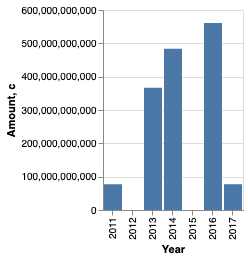

In [82]:
df16 = load_input_table("016.json")

df16["c"] = df16["Amount"] + df16["Variance"]

display(df16)

vl_spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "Year", "type": "nominal"},
        "y": { "field": "Amount", "type": "quantitative"},
        "y2": { "field": "c", "type": "quantitative"},
    }
}

print(json.dumps(vl_spec, indent=4))

VegaLite(vl_spec, df16)

,Actual,Projected,Year
0,1000,0,2001
1,1050,0,2002
2,1110,0,2003
3,1180,0,2004
4,1260,0,2005
...,...,...,...
16,3000,0,2017
17,3210,3210,2018
18,0,4960,2025
19,0,6510,2030


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": "line",
            "encoding": {
                "x": {
                    "field": "Year",
                    "type": "nominal"
                },
                "y": {
                    "field": "Actual",
                    "type": "quantitative"
                }
            }
        },
        {
            "mark": {
                "type": "line",
                "color": "orange"
            },
            "encoding": {
                "x": {
                    "field": "Year",
                    "type": "nominal"
                },
                "y": {
                    "field": "Projected",
                    "type": "quantitative"
                }
            }
        }
    ]
}


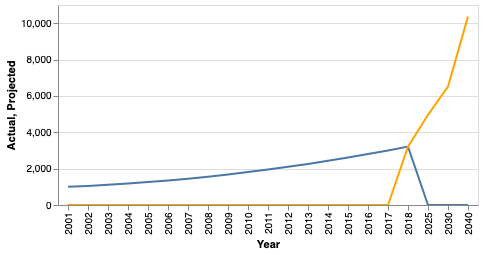

In [83]:
df17 = load_input_table("017.json")

display(df17)
#print(json.dumps(df17.to_dict(orient="records")))

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [{
        "mark": "line",
        "encoding": {
            "x": { "field": "Year", "type": "nominal"},
            "y": { "field": "Actual", "type": "quantitative"},
        }},{
        "mark": {"type": "line", "color": "orange"},
        "encoding": {
            "x": { "field": "Year", "type": "nominal"},
            "y": { "field": "Projected", "type": "quantitative"},
        }
    }]
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df17)

,Item,variable,value
0,Desktop Computers,2012,20
1,Laptops,2012,34
2,Monitors,2012,12
3,Printers,2012,78
4,Desktop Computers,2013,12
...,...,...,...
11,Printers,2014,90
12,Desktop Computers,2015,12
13,Laptops,2015,39
14,Monitors,2015,15


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": "bar",
            "transform": [
                {
                    "filter": "datum.Item == \"Desktop Computers\" || datum.Item == \"Laptops\""
                }
            ],
            "encoding": {
                "x": {
                    "field": "variable",
                    "type": "nominal"
                },
                "y": {
                    "field": "value",
                    "type": "quantitative"
                },
                "color": {
                    "field": "Item",
                    "type": "nominal"
                }
            }
        },
        {
            "mark": {
                "type": "line"
            },
            "transform": [
                {
                    "filter": "datum.Item != \"Desktop Computers\" && datum.Item != \"Laptops\""
                }
            ],
            "encoding": {
           

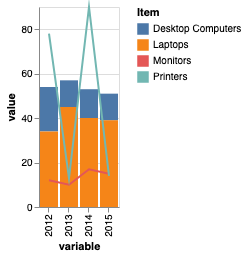

In [84]:
df18 = load_input_table("018.json")

df18 = pd.melt(df18, id_vars='Item', value_vars=["2012", "2013", "2014", "2015"])

display(df18)
#print(json.dumps(df18.to_dict(orient="records")))

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [{
        "mark": "bar",
        "transform": [{"filter": "datum.Item == \"Desktop Computers\" || datum.Item == \"Laptops\""}],
        "encoding": {
            "x": { "field": "variable", "type": "nominal"},
            "y": { "field": "value", "type": "quantitative"},
            "color": {"field": "Item", "type": "nominal"},
        }},{
        "mark": {"type": "line"},
        "transform": [{"filter": "datum.Item != \"Desktop Computers\" && datum.Item != \"Laptops\""}],
        "encoding": {
            "x": { "field": "variable", "type": "nominal"},
            "y": { "field": "value", "type": "quantitative"},
            "color": {"field": "Item", "type": "nominal"},
        }
    }]
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df18)

,cuts,Customer ID,Duration,Purchase Amount,Representative,csum
0,"(-0.2, 10.0]",533,533,533,533,533
1,"(10.0, 20.0]",0,0,0,0,533
2,"(20.0, 30.0]",0,0,0,0,533
3,"(30.0, 40.0]",0,0,0,0,533
4,"(40.0, 50.0]",72,72,72,72,605
...,...,...,...,...,...,...
15,"(150.0, 160.0]",142,142,142,142,1992
16,"(160.0, 170.0]",136,136,136,136,2128
17,"(170.0, 180.0]",136,136,136,136,2264
18,"(180.0, 190.0]",130,130,130,130,2394


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": "bar",
            "encoding": {
                "x": {
                    "field": "cuts",
                    "type": "ordinal",
                    "sort": "none"
                },
                "y": {
                    "field": "Purchase Amount",
                    "type": "quantitative"
                }
            }
        },
        {
            "mark": "line",
            "encoding": {
                "x": {
                    "field": "cuts",
                    "type": "ordinal",
                    "sort": "none"
                },
                "y": {
                    "field": "csum",
                    "type": "quantitative"
                },
                "order": {
                    "field": "id",
                    "type": "ordinal"
                }
            }
        }
    ],
    "resolve": {
        "scale": {
            "y": "in

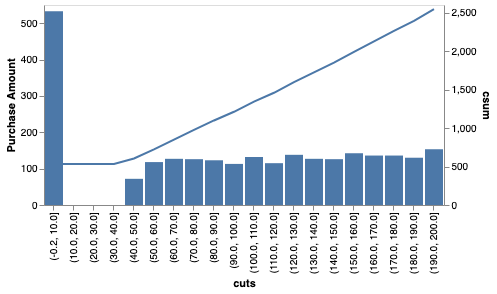

In [85]:
df19 = load_input_table("019.json")

df19["cuts"] = pd.cut(df19['Purchase Amount'], 20)
df19 = df19.groupby(['cuts']).count().reset_index()
df19["csum"] = df19["Purchase Amount"].cumsum()
df19["cuts"] = [str(x) for x in df19["cuts"]]

display(df19)
#print(json.dumps(df19.to_dict(orient="records")))

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [{
        "mark": "bar",
        "encoding": {
            "x": { "field": "cuts", "type": "ordinal", "sort": "none"},
            "y": { "field": "Purchase Amount", "type": "quantitative"},
        }
    },{
        "mark": "line",
        "encoding": {
            "x": { "field": "cuts", "type": "ordinal", "sort": "none"},
            "y": { "field": "csum", "type": "quantitative"},
            "order": {"field": "id", "type": "ordinal"}
        }
    }],
    "resolve": {"scale": {"y": "independent"}}
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df19)

,Product,Country,Amount
0,Apple,Australia,20634
1,Apple,Canada,24867
2,Apple,France,80193
3,Apple,Germany,9082
4,Apple,New Zealand,10332
...,...,...,...
39,Orange,France,2256
40,Orange,Germany,8887
41,Orange,New Zealand,12010
42,Orange,United Kingdom,21744


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": {
            "field": "Country",
            "type": "nominal"
        },
        "color": {
            "field": "Product",
            "type": "nominal"
        },
        "y": {
            "field": "Amount",
            "type": "quantitative"
        }
    }
}


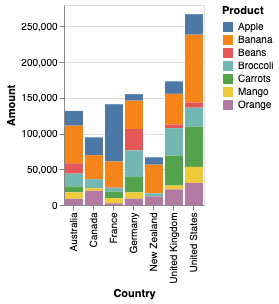

In [86]:
df20 = load_input_table("020.json")
df20 = df20.groupby(['Product', "Country"])["Amount"].sum().reset_index()

display(df20)
#print(json.dumps(df20.to_dict(orient="records")))

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "Country", "type": "nominal"},
        "color": { "field": "Product", "type": "nominal"},
        "y": { "field": "Amount", "type": "quantitative"},
        #"column": { "field": "Country", "type": "nominal"},
        
    }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df20)

,Country,Total Result,variable,value
0,Australia,40492,Beans,14433
1,Canada,12407,Beans,0
2,France,15125,Beans,680
3,Germany,88738,Beans,29905
4,New Zealand,4390,Beans,0
...,...,...,...,...
18,France,15125,Carrots,9104
19,Germany,88738,Carrots,21636
20,New Zealand,4390,Carrots,0
21,United Kingdom,85351,Carrots,41815


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": {
            "field": "variable",
            "type": "nominal"
        },
        "color": {
            "field": "variable",
            "type": "nominal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        },
        "column": {
            "field": "Country",
            "type": "nominal"
        }
    }
}


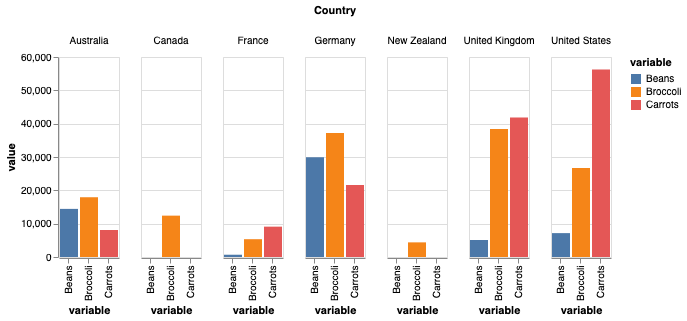

In [87]:
df21 = load_input_table("021.json")

df21 = pd.melt(df21, id_vars=['Country', "Total Result"], value_vars=["Beans", "Broccoli", "Carrots"])
df21 = df21[df21["Country"] != "Total Result"]

display(df21)
#print(json.dumps(df21.to_dict(orient="records")))

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "variable", "type": "nominal"},
        "color": { "field": "variable", "type": "nominal"},
        "y": { "field": "value", "type": "quantitative"},
        "column": { "field": "Country", "type": "nominal"},
        
    }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df21)

,#,Coverage,Event,Event_line,Year
0,1,81,,,1995
1,2,81,,,1996
2,3,81,Medicaid coverage for kids,81,1997
3,4,82,,,1998
4,5,81,Patient bill of rights,81,1999
...,...,...,...,...,...
11,12,83,,,2006
12,13,84,,,2007
13,14,83,,,2008
14,15,83,,,2009


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": "line",
            "encoding": {
                "x": {
                    "field": "Year",
                    "type": "quantitative"
                },
                "y": {
                    "field": "Coverage",
                    "type": "quantitative"
                }
            }
        },
        {
            "mark": "bar",
            "encoding": {
                "x": {
                    "field": "Year",
                    "type": "quantitative"
                },
                "y": {
                    "field": "Event_line",
                    "type": "quantitative"
                }
            }
        },
        {
            "mark": "text",
            "encoding": {
                "x": {
                    "field": "Year",
                    "type": "quantitative"
                },
                "y": {
                    "field": "Event

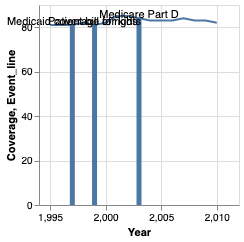

In [88]:
df22 = load_input_table("022.json")

display(df22)

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer":[{
        "mark": "line",
        "encoding": {
            "x": { "field": "Year", "type": "quantitative"},
            "y": { "field": "Coverage", "type": "quantitative"}
        }
    },{
        "mark": "bar",
        "encoding": {
            "x": { "field": "Year", "type": "quantitative"},
            "y": { "field": "Event_line", "type": "quantitative"}
        }
    },{
        "mark": "text",
        "encoding": {
            "x": { "field": "Year", "type": "quantitative"},
            "y": { "field": "Event_line", "type": "quantitative"},
            "text": { "field": "Event", "type": "nominal"},
        }
    }]
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df22)

,Duration,Parts,Start Date,id,End Date
0,10,Foundation,2000-06-01,0,2000-06-01 00:00:00.000000010
1,7,Walls,2000-06-12,1,2000-06-12 00:00:00.000000007
2,10,Roof,2000-06-20,2,2000-06-20 00:00:00.000000010
3,5,"Windows, Doors",2000-07-01,3,2000-07-01 00:00:00.000000005
4,3,Plumbing,2000-07-07,4,2000-07-07 00:00:00.000000003
5,3,Electric,2000-07-07,5,2000-07-07 00:00:00.000000003
6,2,Painting,2000-07-11,6,2000-07-11 00:00:00.000000002
7,2,Flooring,2000-07-13,7,2000-07-13 00:00:00.000000002


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "y": {
            "field": "Parts",
            "type": "nominal",
            "sort": "null"
        },
        "x": {
            "field": "Start Date",
            "type": "temporal"
        },
        "x2": {
            "field": "End Date",
            "type": "temporal"
        }
    }
}


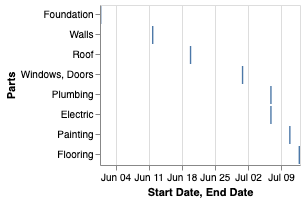

In [89]:
df24 = load_input_table("024.json")

df24['id'] = df24.index
df24["Start Date"] = pd.to_datetime(df24["Start Date"], infer_datetime_format=True)
df24["End Date"] = df24["Start Date"] + pd.TimedeltaIndex(df24['Duration'], unit="D")

display(df24)

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "y": { "field": "Parts", "type": "nominal", "sort": "null"},
        "x": { "field": "Start Date", "type": "temporal"},
        "x2": { "field": "End Date", "type": "temporal"}
    }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df24)

,Complaint Type,Count,cumsum
1,Overpriced,789,789
9,Small portions,621,1410
7,Wait time,109,1519
2,Food is tasteless,65,1584
8,No atmosphere,45,1629
5,Not clean,30,1659
0,Too noisy,27,1686
4,Food is too salty,15,1701
6,Unfriendly staff,12,1713
3,Food not fresh,9,1722


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": "bar",
            "encoding": {
                "x": {
                    "field": "Complaint Type",
                    "type": "nominal",
                    "sort": null
                },
                "y": {
                    "field": "Count",
                    "type": "quantitative"
                }
            }
        },
        {
            "mark": {
                "type": "line",
                "color": "red"
            },
            "encoding": {
                "x": {
                    "field": "Complaint Type",
                    "type": "nominal",
                    "sort": null
                },
                "y": {
                    "field": "cumsum",
                    "type": "quantitative"
                },
                "order": {
                    "field": "id",
                    "type": "ordinal"
                }
       

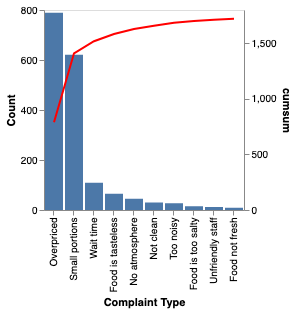

In [90]:
df25 = load_input_table("025.json")

df25 = df25.sort_values(by='Count', ascending=False)
df25["cumsum"] = df25["Count"].cumsum()

display(df25)
#print(json.dumps(df25.to_dict(orient="records")))

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer":[{
        "mark": "bar",
        "encoding": {
            "x": { "field": "Complaint Type", "type": "nominal", "sort": None},
            "y": { "field": "Count", "type": "quantitative"}
        }
    },{
        "mark": {"type": "line", "color": "red"},
        "encoding": {
            "x": { "field": "Complaint Type", "type": "nominal", "sort": None},
            "y": { "field": "cumsum", "type": "quantitative"},
            "order": { "field": "id", "type": "ordinal"}
        }
    }],
  "resolve": {"scale": {"y": "independent"}}
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df25)

,Period,variable,value
0,Actual,0,120.000000
1,Interval = 2,0,0.000000
2,Interval = 4,0,0.000000
3,Interval = 6,0,0.000000
4,Actual,1,150.000000
...,...,...,...
43,Interval = 6,10,536.666667
44,Actual,11,950.000000
45,Interval = 2,11,725.000000
46,Interval = 4,11,700.000000


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "x": {
            "field": "variable",
            "type": "nominal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        },
        "color": {
            "field": "Period",
            "type": "nominal"
        }
    }
}


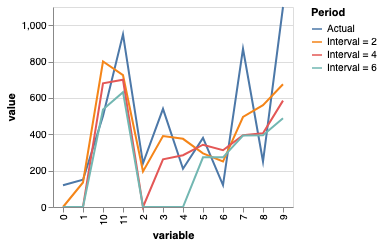

In [102]:
df27 = load_input_table("027.json")

df27 = pd.melt(df27, id_vars=['Period'], value_vars=["0", "1", "2", "3", "4", '5', '6', "7", "8", "9", "10", "11"])

display(df27)
#print(json.dumps(df27.to_dict(orient="records")))

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "x": { "field": "variable", "type": "nominal"},
        "y": { "field": "value", "type": "quantitative"},
        "color": { "field": "Period", "type": "nominal"},
    }
   
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df27)

,cuts,Number of students
0,"(19.0, 26.0]",9
1,"(26.0, 32.0]",3
2,"(32.0, 39.0]",2
3,"(39.0, 45.0]",2
4,"(45.0, 52.0]",2


[{"cuts": "(19.0, 26.0]", "Number of students": 9}, {"cuts": "(26.0, 32.0]", "Number of students": 3}, {"cuts": "(32.0, 39.0]", "Number of students": 2}, {"cuts": "(39.0, 45.0]", "Number of students": 2}, {"cuts": "(45.0, 52.0]", "Number of students": 2}]
{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": {
            "field": "cuts",
            "type": "nominal"
        },
        "y": {
            "field": "Number of students",
            "type": "quantitative"
        }
    }
}


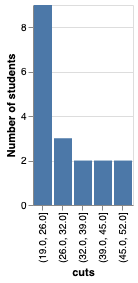

In [109]:
df28 = load_input_table("028.json")

df28["cuts"] = pd.cut(df28['Number of students'], 5, precision=0)
df28 = df28.groupby(['cuts']).count().reset_index()
df28["cuts"] = [str(x) for x in df28["cuts"]]

display(df28)
print(json.dumps(df28.to_dict(orient="records")))

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "cuts", "type": "nominal"},
        "y": { "field": "Number of students", "type": "quantitative"},
    }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df28)

,Sport,Rank,variable,value,Archery
0,Archery,55,Endurance,2.88,True
1,Auto Racing,32,Endurance,5.88,False
2,Badminton,30,Endurance,5.25,False
3,Baseball/Softball,9,Endurance,4.63,False
4,Basketball,4,Endurance,7.38,False
...,...,...,...,...,...
595,Volleyball,20,Analytical Aptitude,5.88,False
596,Water Polo,11,Analytical Aptitude,5.63,False
597,Water Skiing,46,Analytical Aptitude,3.25,False
598,Weight-Lifting,44,Analytical Aptitude,2.38,False


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "point",
    "encoding": {
        "x": {
            "field": "value",
            "type": "quantitative"
        },
        "y": {
            "field": "variable",
            "type": "nominal"
        },
        "size": {
            "field": "Archery",
            "type": "nominal"
        }
    }
}


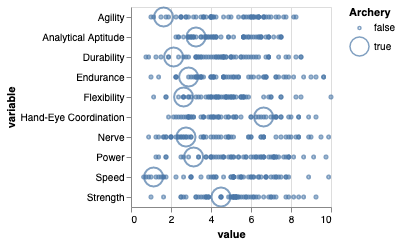

In [110]:
df29 = load_input_table("029.json")

df29 = pd.melt(df29, id_vars=['Sport', "Rank"], value_vars=["Endurance", "Strength", "Power", "Speed", "Agility", "Flexibility", "Nerve", "Durability", "Hand-Eye Coordination", "Analytical Aptitude"])
df29["Archery"] = df29["Sport"] == "Archery"

display(df29)

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "point",
    "encoding": {
        "x": { "field": "value", "type": "quantitative"},
        "y": { "field": "variable", "type": "nominal"},
        "size": {"field": "Archery", 'type': "nominal"}
    }
   
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df29)

,Sport,Rank,variable,value,Archery
0,Archery,55,Endurance,2.88,True
1,Auto Racing,32,Endurance,5.88,False
2,Badminton,30,Endurance,5.25,False
3,Baseball/Softball,9,Endurance,4.63,False
4,Basketball,4,Endurance,7.38,False
...,...,...,...,...,...
595,Volleyball,20,Analytical Aptitude,5.88,False
596,Water Polo,11,Analytical Aptitude,5.63,False
597,Water Skiing,46,Analytical Aptitude,3.25,False
598,Weight-Lifting,44,Analytical Aptitude,2.38,False


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "circle",
    "encoding": {
        "y": {
            "field": "value",
            "type": "quantitative"
        },
        "column": {
            "field": "variable",
            "type": "nominal"
        },
        "size": {
            "field": "Archery",
            "type": "nominal"
        }
    }
}


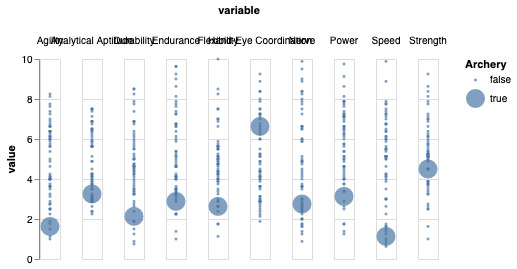

In [111]:
df30 = load_input_table("030.json")

df30 = pd.melt(df30, id_vars=['Sport', "Rank"], 
                     value_vars=["Endurance", "Strength", "Power", "Speed", "Agility", "Flexibility", "Nerve", "Durability", "Hand-Eye Coordination", "Analytical Aptitude"])
df30["Archery"] = df30["Sport"] == "Archery"

display(df30)

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "circle",
    "encoding": {
        "y": { "field": "value", "type": "quantitative"},
        "column": {"field": "variable", 'type': "nominal"},
        "size": {"field": "Archery", 'type': "nominal"}
    }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df30)

,Business Group,Emp Num,Group Name,Noise,Performance Rating,Rating 17 (number),Ratings X,Salary Increase $,Total Increase
0,4,11505,Development,-0.152,Successful Performance,3,46.098,0.0,#N/A
1,4,11529,Development,0.079,Successful Performance,3,46.329,1644.0,1644
2,4,11537,Development,0.639,Outstanding Performance,4,49.389,0.0,#N/A
3,4,11538,Development,-0.406,Not Meeting,1,40.844,0.0,#N/A
4,4,11539,Development,-0.222,Achieved Most,2,43.528,0.0,#N/A
...,...,...,...,...,...,...,...,...,...
3681,6,53633,Support,-0.489,Successful Performance,3,65.761,1256.0,1256
3682,4,53644,Development,-0.281,Successful Performance,3,45.969,527.0,527
3683,6,53657,Support,-0.507,Successful Performance,3,65.743,1621.0,1621
3684,6,53659,Support,0.031,Achieved Most,2,63.781,0.0,#N/A


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "Performance Rating",
            "type": "nominal"
        },
        "color": {
            "field": "Performance Rating",
            "type": "nominal"
        },
        "column": {
            "field": "Group Name",
            "type": "nominal"
        },
        "y": {
            "field": "Salary Increase $",
            "type": "quantitative"
        }
    }
}


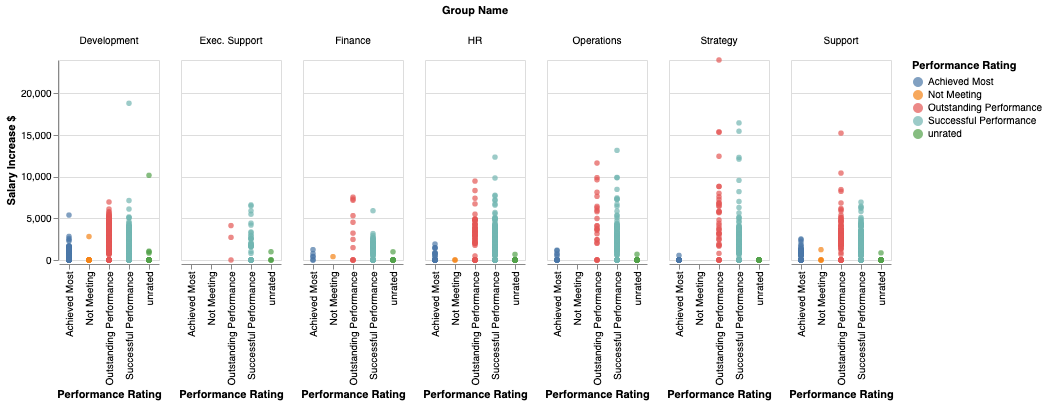

In [112]:
df31 = load_input_table("031.json")

display(df31)

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "circle",
    "encoding": {
        "x": { "field": "Performance Rating", "type": "nominal"},
        "color": { "field": "Performance Rating", "type": "nominal"},
        "column": {"field": "Group Name", 'type': "nominal"},
        "y": {"field": "Salary Increase $", 'type': "quantitative"}
    }
   
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df31)

,activity,variable,value
0,Playing billiards,0,0.000032
1,Dancing,0,0.000168
2,Softball,0,0.000000
3,Bowling,0,0.000012
4,Playing volleyball,0,0.000000
...,...,...,...
8059,Doing aerobics,1435,0.000000
8060,Walking,1435,0.000044
8061,Running,1435,0.000014
8062,"Working out, unspecified",1435,0.000035


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": {
            "field": "variable",
            "type": "quantitative"
        },
        "column": {
            "field": "activity",
            "type": "nominal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        }
    }
}


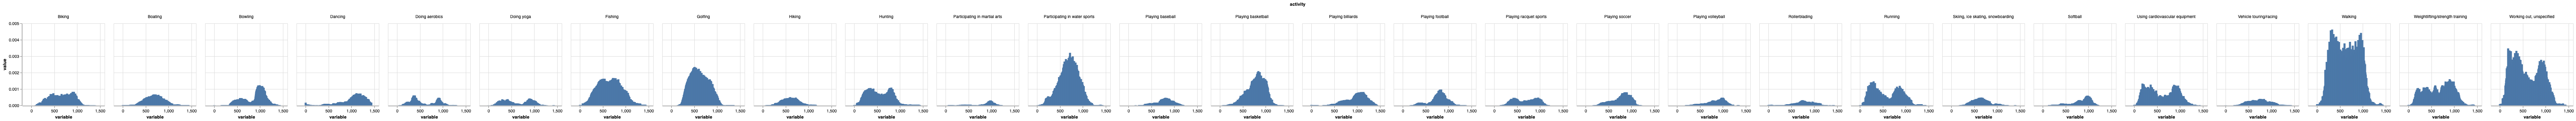

In [113]:
df33 = load_input_table("033.json")

df33 = pd.melt(df33, id_vars="activity", value_vars=['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '95', '100', '105', '110', '115', '120', '125', '130', '135', '140', '145', '150', '155', '160', '165', '170', '175', '180', '185', '190', '195', '200', '205', '210', '215', '220', '225', '230', '235', '240', '245', '250', '255', '260', '265', '270', '275', '280', '285', '290', '295', '300', '305', '310', '315', '320', '325', '330', '335', '340', '345', '350', '355', '360', '365', '370', '375', '380', '385', '390', '395', '400', '405', '410', '415', '420', '425', '430', '435', '440', '445', '450', '455', '460', '465', '470', '475', '480', '485', '490', '495', '500', '505', '510', '515', '520', '525', '530', '535', '540', '545', '550', '555', '560', '565', '570', '575', '580', '585', '590', '595', '600', '605', '610', '615', '620', '625', '630', '635', '640', '645', '650', '655', '660', '665', '670', '675', '680', '685', '690', '695', '700', '705', '710', '715', '720', '725', '730', '735', '740', '745', '750', '755', '760', '765', '770', '775', '780', '785', '790', '795', '800', '805', '810', '815', '820', '825', '830', '835', '840', '845', '850', '855', '860', '865', '870', '875', '880', '885', '890', '895', '900', '905', '910', '915', '920', '925', '930', '935', '940', '945', '950', '955', '960', '965', '970', '975', '980', '985', '990', '995', '1000', '1005', '1010', '1015', '1020', '1025', '1030', '1035', '1040', '1045', '1050', '1055', '1060', '1065', '1070', '1075', '1080', '1085', '1090', '1095', '1100', '1105', '1110', '1115', '1120', '1125', '1130', '1135', '1140', '1145', '1150', '1155', '1160', '1165', '1170', '1175', '1180', '1185', '1190', '1195', '1200', '1205', '1210', '1215', '1220', '1225', '1230', '1235', '1240', '1245', '1250', '1255', '1260', '1265', '1270', '1275', '1280', '1285', '1290', '1295', '1300', '1305', '1310', '1315', '1320', '1325', '1330', '1335', '1340', '1345', '1350', '1355', '1360', '1365', '1370', '1375', '1380', '1385', '1390', '1395', '1400', '1405', '1410', '1415', '1420', '1425', '1430', '1435'])

display(df33)

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "variable", "type": "quantitative"},
        "column": {"field": "activity", 'type': "nominal"},
        "y": {"field": "value", 'type': "quantitative"}
    }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df33)

,Timeline,variable,value
11,Jun-16,Forecast,1097
12,Jul-16,Forecast,939.925
13,Aug-16,Forecast,924.496
14,Sep-16,Forecast,909.067
26,Jun-16,Lower Confidence Bound,1097
...,...,...,...
52,Feb-16,Values,742
53,Mar-16,Values,1955
54,Apr-16,Values,1466
55,May-16,Values,584


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "x": {
            "field": "Timeline",
            "type": "temporal"
        },
        "color": {
            "field": "variable",
            "type": "nominal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        }
    }
}


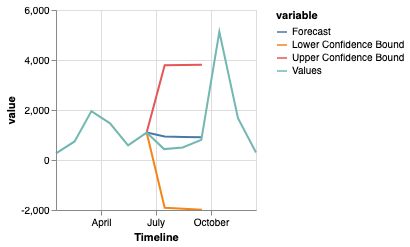

In [114]:
df34 = load_input_table("034.json")

df34 = pd.melt(df34, id_vars="Timeline", value_vars=["Forecast", "Lower Confidence Bound", "Upper Confidence Bound", "Values"])
df34 = df34[df34["value"] != ""]

display(df34)

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "x": { "field": "Timeline", "type": "temporal"},
        "color": {"field": "variable", 'type': "nominal"},
        "y": {"field": "value", 'type': "quantitative"}
    }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df34)

,DATA,variable,value
0,A,Lower,80
1,B,Lower,103
2,C,Lower,106
3,D,Lower,75
4,E,Lower,85
...,...,...,...
10,A,Value,100
11,B,Value,120
12,C,Value,140
13,D,Value,80


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": {
                "type": "bar",
                "opacity": 0.5
            },
            "transform": [
                {
                    "filter": "datum.variable == \"Value\""
                }
            ],
            "encoding": {
                "x": {
                    "field": "DATA",
                    "type": "nominal"
                },
                "y": {
                    "field": "value",
                    "type": "quantitative"
                }
            }
        },
        {
            "mark": {
                "type": "point"
            },
            "transform": [
                {
                    "filter": "datum.variable != \"Value\""
                }
            ],
            "encoding": {
                "x": {
                    "field": "DATA",
                    "type": "nominal"
                },
                "y":

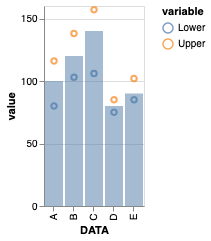

In [115]:
df35 = load_input_table("035.json")
df35 = pd.melt(df35, id_vars=["DATA"], value_vars=["Lower", "Upper", "Value"])

display(df35)

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
          "mark": {"type": "bar", "opacity": 0.5},
          "transform": [{"filter": "datum.variable == \"Value\""}],
          "encoding": { "x": {"field": "DATA", "type": "nominal"},
                        "y": { "field": "value", "type": "quantitative" }}
        },
        {
          "mark": {"type": "point"},
          "transform": [{"filter": "datum.variable != \"Value\""}],
          "encoding": {
            "x": {"field": "DATA", "type": "nominal"},
            "y": {"field": "value", "type": "quantitative"},
            "color": {"field": "variable", "type": "nominal"}
          }
        }
    ]
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df35)

,Close,Date,variable,value,color
0,7210.770020,1-Jul-05,VolumeDiff,NaN,False
1,7212.080078,4-Jul-05,VolumeDiff,800.0,True
2,7271.540039,11-Jul-05,VolumeDiff,200.0,False
3,7423.250000,18-Jul-05,VolumeDiff,600.0,False
4,7635.419922,25-Jul-05,VolumeDiff,5500.0,True
...,...,...,...,...,...
1049,28092.789060,29-Jun-15,Volume,10300.0,True
1050,27661.400390,6-Jul-15,Volume,9800.0,True
1051,28463.310550,13-Jul-15,Volume,7300.0,True
1052,28112.310550,20-Jul-15,Volume,9200.0,True


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "area",
    "encoding": {
        "x": {
            "field": "Date",
            "type": "temporal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        },
        "color": {
            "field": "color",
            "type": "nominal"
        },
        "column": {
            "field": "variable",
            "type": "nominal"
        }
    }
}


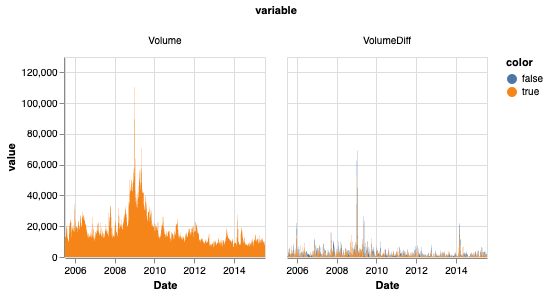

In [116]:
df36 = load_input_table("036.json")
df36["VolumeDiff"] = df36["Volume"].diff()
df36 = pd.melt(df36, id_vars=["Close", "Date"], value_vars=["VolumeDiff", "Volume"])
df36["color"] = df36['value'] > 0
df36["value"] = df36["value"].abs()

display(df36)
#print(df36.to_json(orient="records"))

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
      "mark": "area",
      "encoding": {
        "x": {"field": "Date", "type": "temporal"},
        "y": {"field": "value", "type": "quantitative"},
        "color": {"field": "color", "type": "nominal"},
        "column": {"field": "variable", "type": "nominal" }
      }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df36)

,TOTAL,Category,variable,value
0,645,HOME APPLIANCES,<-10%,-0.300775
1,568,COMPUTERS,<-10%,-0.306338
2,355,CAMERAS & CAMCORDERS,<-10%,-0.309859
3,265,CELL PHONES,<-10%,-0.301887
4,205,TV & VIDEO,<-10%,-0.302439
...,...,...,...,...
27,265,CELL PHONES,>=0%,0.200000
28,205,TV & VIDEO,>=0%,0.204878
29,166,GAMES & TOYS,>=0%,0.150602
30,100,AUDIO,>=0%,0.130000


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "color": {
            "field": "variable",
            "type": "nominal"
        },
        "y": {
            "field": "Category",
            "type": "nominal"
        },
        "x": {
            "field": "value",
            "type": "quantitative"
        }
    }
}


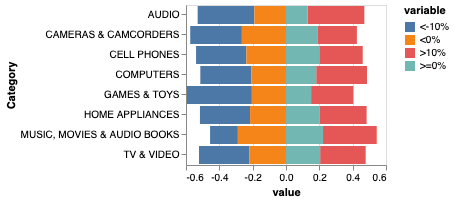

In [117]:
df37 = load_input_table("037.json")

df37 = pd.melt(df37, id_vars=["TOTAL", "Category"], value_vars=["<-10%", "<0%", ">10%", ">=0%"])
df37['value'].mask(df37['variable'] == "<-10%", -df37["value"], inplace=True)
df37['value'].mask(df37['variable'] == "<0%", -df37["value"], inplace=True)

df37["value"] = df37["value"] / df37["TOTAL"]

display(df37)

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {"type": "bar"},
    "encoding": {
        "color": {"field": "variable", "type": "nominal"},
        "y": {"field": "Category", "type": "nominal"},
        "x": { "field": "value", "type": "quantitative"}    
    }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df37)

,Job Type,left,right,label
0,Accountant,22880.000000,64737.190476,lower
1,Analyst,10000.000000,62583.737374,lower
2,CXO or Top Mgmt.,16000.000000,125615.384615,lower
3,Consultant,12000.000000,98388.888889,lower
4,Controller,24000.000000,87813.235294,lower
...,...,...,...,...
5,Engineer,72056.153846,130000.000000,higher
6,Manager,77581.710345,400000.000000,higher
7,Misc.,83820.333333,90000.000000,higher
8,Reporting,58200.000000,92000.000000,higher


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "y": {
            "field": "Job Type",
            "type": "nominal"
        },
        "x": {
            "field": "left",
            "type": "quantitative"
        },
        "x2": {
            "field": "right",
            "type": "quantitative"
        },
        "color": {
            "field": "label",
            "type": "nominal"
        }
    }
}


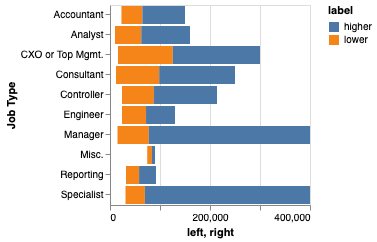

In [118]:
df38 = load_input_table("038.json")

df38_0 = df38.groupby("Job Type")['Salary in USD'].mean()
df38_1 = df38.groupby("Job Type")['Salary in USD'].max()
df38_2 = df38.groupby("Job Type")['Salary in USD'].min()

df38 = pd.concat([df38_0, df38_1, df38_2], axis=1).reset_index()
df38.columns = ["Job Type", "mean", "max", "min"]

df38_r = df38[["Job Type", "mean", "max"]]
df38_r.columns=["Job Type", "left", "right"]
df38_r["label"] = "higher"

df38_l = df38[["Job Type", "min", "mean"]]
df38_l.columns=["Job Type", "left", "right"]
df38_l["label"] = "lower"

df38 = pd.concat([df38_l, df38_r])

display(df38)
#print(df38.to_json(orient="records"))

spec = {
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {"type": "bar"},
    "encoding": {
        "y": {"field": "Job Type", "type": "nominal"},
        "x": { "field": "left", "type": "quantitative"},
        "x2": { "field": "right", "type": "quantitative"},
        "color":{"field": "label", "type": "nominal"}
    }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df38)

,Job Type,Salary in USD
0,Analyst,58000
1,Engineer,54000
2,Analyst,49000
3,Engineer,85000
4,Engineer,75000
...,...,...
612,Analyst,46000
613,Analyst,115000
614,Analyst,40000
615,Analyst,46359


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "boxplot",
        "extent": "min-max"
    },
    "encoding": {
        "x": {
            "field": "Salary in USD",
            "type": "quantitative"
        },
        "y": {
            "field": "Job Type",
            "type": "nominal"
        }
    }
}


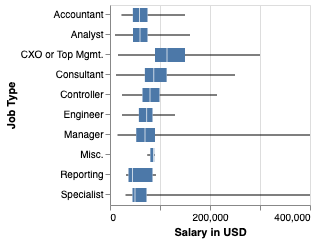

In [119]:
df38 = load_input_table("038.json")

display(df38)

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": {
    "type": "boxplot",
    "extent": "min-max"
  },
  "encoding": {
    "x": {"field": "Salary in USD","type": "quantitative"},
    "y": {
      "field": "Job Type",
      "type": "nominal",
    }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df38)

,Year,loc,Bisc,Choc
0,2007,NORTH,6.0,14.0
1,2007,SOUTH,4.0,10.0
2,2007,WEST,4.0,6.0
3,2008,NORTH,6.7,18.0
4,2008,SOUTH,5.0,11.0
...,...,...,...,...
7,2009,SOUTH,5.7,14.0
8,2009,WEST,5.7,12.0
9,2010,NORTH,8.0,21.0
10,2010,SOUTH,6.0,16.0


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "area"
    },
    "encoding": {
        "x": {
            "field": "Year",
            "type": "ordinal"
        },
        "y": {
            "field": "Bisc",
            "type": "quantitative"
        },
        "y2": {
            "field": "Choc",
            "type": "quantitative"
        },
        "column": {
            "field": "loc",
            "type": "nominal"
        }
    }
}


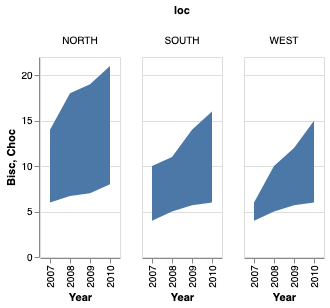

In [120]:
df39 = load_input_table("039.json")

df39 = pd.melt(df39, id_vars=["Year"], 
               value_vars=["NORTH-Bisc", "NORTH-Choc", "SOUTH-Bisc", "SOUTH-Choc", "WEST-Bisc", "WEST-Choc"])
split_col = df39["variable"].str.split("-", expand=True)
df39["loc"] = split_col[0]
df39["type"] = split_col[1]
df39 = df39.pivot_table(index=["Year", "loc"], columns='type', values=['value']).reset_index()
df39.columns = ["Year", "loc", "Bisc", "Choc"]

display(df39)

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": {
    "type": "area"
  },
  "encoding": {
    "x": {"field": "Year","type": "ordinal"},
    "y": { "field": "Bisc", "type": "quantitative" },
    "y2": { "field": "Choc", "type": "quantitative" },
    "column": { "field": "loc", "type": "nominal" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df39)

,Value,Win / Loss,id,end,start
0,10,Win,0,10,0
1,2,Loss,1,12,10
2,12,Win,2,24,12
3,4,Loss,3,28,24
4,5,Win,4,33,28
...,...,...,...,...,...
8,12,Win,8,88,76
9,3,Loss,9,91,88
10,4,Win,10,95,91
11,4,Loss,11,99,95


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "x": {
            "field": "start",
            "type": "quantitative"
        },
        "x2": {
            "field": "end",
            "type": "quantitative"
        },
        "color": {
            "field": "Win / Loss",
            "type": "nominal"
        },
        "y": {
            "field": "Win / Loss",
            "type": "nominal"
        }
    }
}


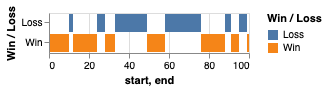

In [121]:
df40 = load_input_table("040.json")
df40["id"] = df40.index

df40["end"] = df40["Value"].cumsum()
df40["start"] = df40["end"] - df40["Value"]

display(df40)

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": {
    "type": "bar"
  },
  "encoding": {
    "x": {"field": "start","type": "quantitative"},
    "x2": {"field": "end","type": "quantitative"},
    "color": { "field": "Win / Loss", "type": "nominal" },
    "y": { "field": "Win / Loss", "type": "nominal" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df40)

,Year,variable,value
0,1950,Cod,2716706
1,1951,Cod,3861166
2,1952,Cod,4396174
3,1953,Cod,3901176
4,1954,Cod,4412721
...,...,...,...
25,1951,Tuna,34829755
26,1952,Tuna,31061481
27,1953,Tuna,23225423
28,1954,Tuna,20798126


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "line"
    },
    "encoding": {
        "x": {
            "field": "Year",
            "type": "ordinal"
        },
        "color": {
            "field": "variable",
            "type": "nominal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        }
    }
}


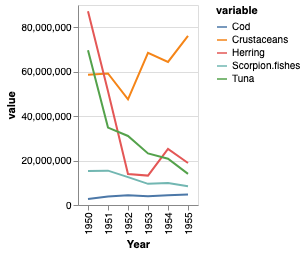

In [122]:
df41 = load_input_table("041.json")

df41 = pd.melt(df41, id_vars='Year', value_vars=["Cod", "Crustaceans", "Herring", "Scorpion.fishes", "Tuna"])

display(df41)
# print(df41.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": {
    "type": "line"
  },
  "encoding": {
    "x": {"field": "Year", "type": "ordinal"},
    "color": { "field": "variable", "type": "nominal" },
    "y": { "field": "value", "type": "quantitative" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df41)

,date,variable,value
0,2002-01-01,var0,100.0000
1,2002-02-01,var0,87.6560
2,2002-03-01,var0,78.7880
3,2002-04-01,var0,64.8441
4,2002-05-01,var0,83.3027
...,...,...,...
195,2009-12-01,var1,167.6651
196,2010-01-01,var1,157.8813
197,2010-02-01,var1,162.9670
198,2010-03-01,var1,159.8805


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "line"
    },
    "encoding": {
        "x": {
            "field": "date",
            "type": "ordinal"
        },
        "color": {
            "field": "variable",
            "type": "nominal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        }
    }
}


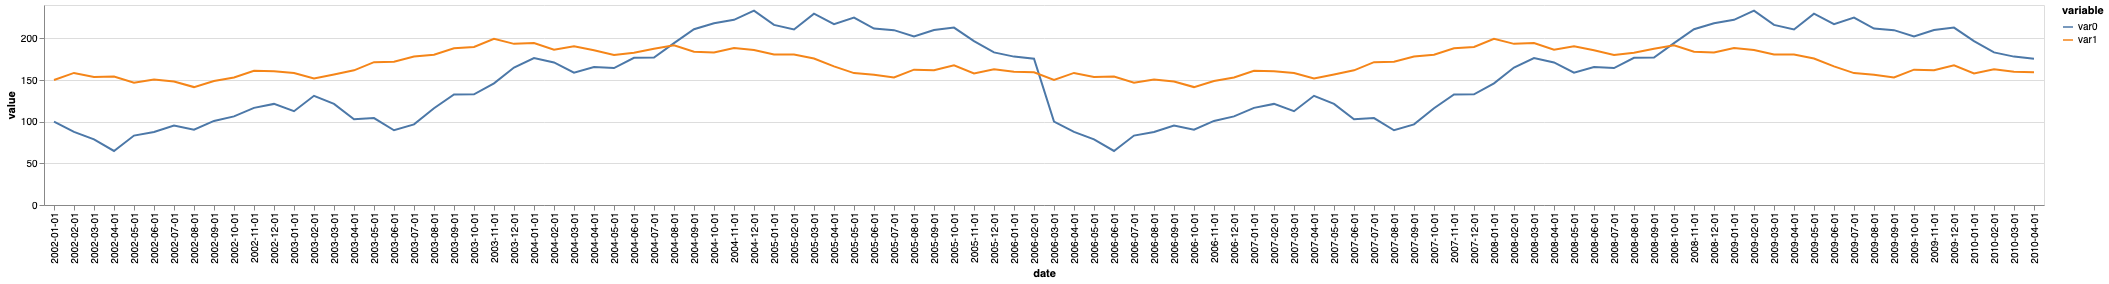

In [123]:
df42 = load_input_table("042.json")

df42 = pd.melt(df42, id_vars='date', value_vars=["var0", "var1"])

display(df42)
#print(df42.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": {
    "type": "line"
  },
  "encoding": {
    "x": {"field": "date", "type": "ordinal"},
    "color": { "field": "variable", "type": "nominal" },
    "y": { "field": "value", "type": "quantitative" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df42)

,variable,value,depth,price,table,x,y,z,carat
0,clarity,I1,3,3,3,3,3,3,3
1,clarity,IF,1,1,1,1,1,1,1
2,clarity,SI1,19,19,19,19,19,19,19
3,clarity,SI2,25,25,25,25,25,25,25
4,clarity,VS1,10,10,10,10,10,10,10
...,...,...,...,...,...,...,...,...,...
15,cut,Fair,3,3,3,3,3,3,3
16,cut,Good,9,9,9,9,9,9,9
17,cut,Ideal,45,45,45,45,45,45,45
18,cut,Premium,18,18,18,18,18,18,18


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "x": {
            "field": "value",
            "type": "nominal"
        },
        "column": {
            "field": "variable",
            "type": "nominal"
        },
        "y": {
            "field": "depth",
            "type": "quantitative"
        }
    }
}


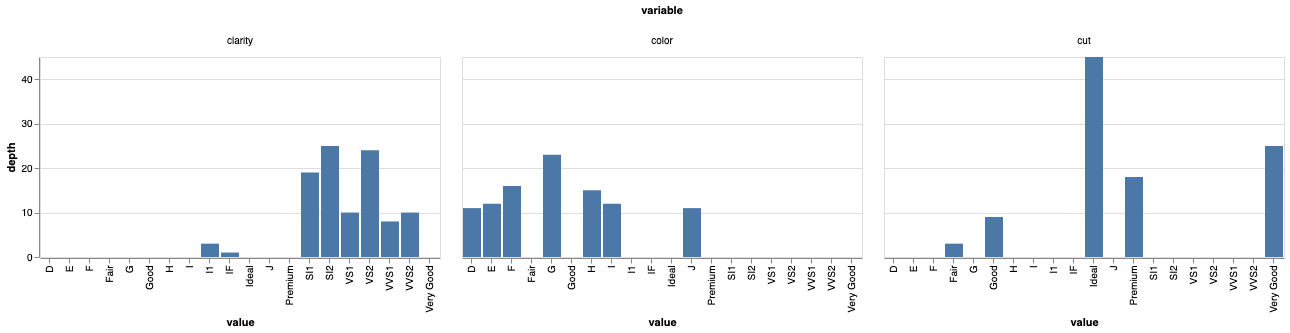

In [124]:
df43 = load_input_table("043.json")

df43 = pd.melt(df43, id_vars=["depth", "price", "table", "x", "y", "z", "carat"], value_vars=["clarity", "color", "cut"])
df43 = df43.groupby(['variable', "value"]).count().reset_index()

display(df43)

#print(df43.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": {
    "type": "bar"
  },
  "encoding": {
    "x": {"field": "value", "type": "nominal"},
    "column": { "field": "variable", "type": "nominal" },
    "y": { "field": "depth", "type": "quantitative" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df43)

,Species,variable,value
0,setosa,Petal.Length,1.462
1,setosa,Petal.Width,0.246
2,setosa,Sepal.Length,5.006
3,setosa,Sepal.Width,3.428
4,versicolor,Petal.Length,4.260
...,...,...,...
7,versicolor,Sepal.Width,2.770
8,virginica,Petal.Length,5.552
9,virginica,Petal.Width,2.026
10,virginica,Sepal.Length,6.588


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "x": {
            "field": "Species",
            "type": "nominal"
        },
        "color": {
            "field": "variable",
            "type": "nominal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        }
    }
}


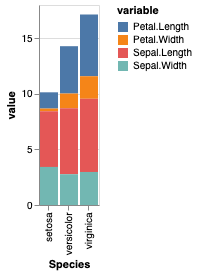

In [125]:
df44 = load_input_table("044.json")

df44 = pd.melt(df44, id_vars=["Species"], value_vars=["Petal.Length","Petal.Width","Sepal.Length","Sepal.Width"])
df44 = df44.groupby(['Species', "variable"]).mean().reset_index()

display(df44)
#print(df44.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": {
    "type": "bar"
  },
  "encoding": {
    "x": {"field": "Species", "type": "nominal"},
    "color": { "field": "variable", "type": "nominal" },
    "y": { "field": "value", "type": "quantitative" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df44)

,X1,variable,value
0,Diversity,B1,5.1
1,Endangerment,B1,4.9
2,Marketability,B1,4.7
3,Total,B1,4.6
4,Diversity,B2,3.5
...,...,...,...
11,Total,B3,1.5
12,Diversity,B4,7.1
13,Endangerment,B4,4.7
14,Marketability,B4,3.2


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "x": {
            "field": "X1",
            "type": "nominal"
        },
        "color": {
            "field": "variable",
            "type": "nominal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        }
    }
}


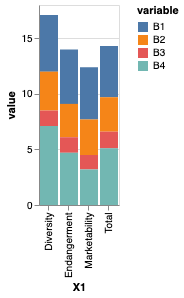

In [126]:
df45 = load_input_table("045.json")

df45 = pd.melt(df45, id_vars=["X1"], value_vars=["B1", "B2", "B3", "B4"])

display(df45)
#print(df45.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": {
    "type": "bar"
  },
  "encoding": {
    "x": {"field": "X1", "type": "nominal"},
    "color": { "field": "variable", "type": "nominal" },
    "y": { "field": "value", "type": "quantitative" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df45)

,date,Y2K,variable,value
0,2012-07-01,False,psavert,6.6
1,2001-09-01,False,psavert,6.3
2,2011-08-01,False,psavert,6.2
3,2005-07-01,False,psavert,1.9
4,1989-05-01,True,psavert,7.6
...,...,...,...,...
95,2001-06-01,False,uempmed,6.0
96,2007-10-01,False,uempmed,8.4
97,1981-04-01,True,uempmed,7.4
98,1984-08-01,True,uempmed,7.3


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "line"
    },
    "encoding": {
        "x": {
            "field": "date",
            "type": "temporal"
        },
        "color": {
            "field": "variable",
            "type": "nominal"
        },
        "strokeOpacity": {
            "field": "Y2K",
            "type": "nominal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        }
    }
}


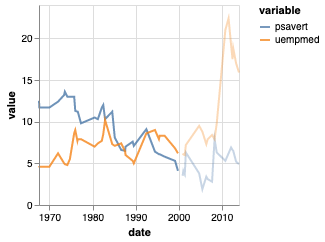

In [149]:
df46 = load_input_table("046.json")

df46["Y2K"] = pd.to_datetime(df46['date']).dt.year < 2000
df46 = pd.melt(df46, id_vars=["date", "Y2K"], value_vars=["psavert", "uempmed"])

display(df46)
#print(df46.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "line" },
  "encoding": {
    "x": {"field": "date", "type": "temporal"},
    "color": { "field": "variable", "type": "nominal" },
    "strokeOpacity": { "field": "Y2K", "type": "nominal" },
    "y": { "field": "value", "type": "quantitative" }
  }
}

#display(spec)
print(json.dumps(spec, indent=4))

VegaLite(spec, df46)

,label,variable,value
0,Label1,ok,0.0
1,Label2,ok,0.5
2,Label3,ok,0.4
3,Label4,ok,0.9
4,Label5,ok,0.4
...,...,...,...
11,Label4,err,0.1
12,Label5,err,0.6
13,Label6,err,0.1
14,Label7,err,0.2


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "x": {
            "field": "label",
            "type": "nominal"
        },
        "color": {
            "field": "variable",
            "type": "nominal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        }
    }
}


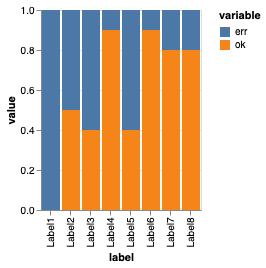

In [130]:
df47 = load_input_table("047.json")

df47["err"] = 1 - df47['ok']
df47 = pd.melt(df47, id_vars=["label"], value_vars=["ok", "err"])

display(df47)
#print(df47.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "bar" },
  "encoding": {
    "x": {"field": "label", "type": "nominal"},
    "color": { "field": "variable", "type": "nominal" },
    "y": { "field": "value", "type": "quantitative" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df47)

,category,totalABC,variable,value
0,group1,17,A,0.117647
1,group2,163,A,0.233129
2,group1,17,B,0.823529
3,group2,163,B,0.705521
4,group1,17,C,0.058824
5,group2,163,C,0.061350


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "x": {
            "field": "category",
            "type": "nominal"
        },
        "color": {
            "field": "variable",
            "type": "nominal"
        },
        "y": {
            "field": "value",
            "type": "quantitative"
        }
    }
}


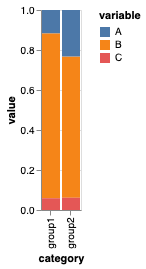

In [131]:
df48 = load_input_table("048.json")

df48 = df48.groupby("category").sum().reset_index()
df48 = pd.melt(df48, id_vars=["category", "totalABC"], value_vars=["A", "B", "C"])
df48["value"] = df48["value"] / df48["totalABC"]

display(df48)

#print(df48.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "bar" },
  "encoding": {
    "x": {"field": "category", "type": "nominal"},
    "color": { "field": "variable", "type": "nominal" },
    "y": { "field": "value", "type": "quantitative" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df48)

scenario1,row,drain,measured,simulated
0,0.5,None,40.0,41.0
1,0.5,drain,40.0,39.9
2,0.8,None,55.0,56.0
3,0.8,drain,55.0,55.3
4,adj21,None,23.0,22.0
...,...,...,...,...
7,adj22,drain,27.0,27.2
8,raw21,None,55.0,54.0
9,raw21,drain,55.0,54.5
10,raw22,None,60.0,59.0


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "point"
    },
    "encoding": {
        "x": {
            "field": "measured",
            "type": "nominal"
        },
        "color": {
            "field": "row",
            "type": "nominal"
        },
        "y": {
            "field": "simulated",
            "type": "quantitative"
        },
        "column": {
            "field": "drain",
            "type": "nominal"
        }
    }
}


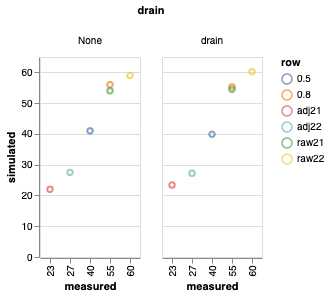

In [132]:
import numpy as np

df49 = load_input_table("049-2.json")

splits = pd.DataFrame(df49["scenario"].str.split('_', 2).tolist(), columns = ['scenario1','row', "drain"])
df49 = pd.concat([df49, splits], axis=1).reset_index()
df49["drain"] = np.where(df49["drain"] == "drain", "drain", "None")
df49 = df49.pivot_table(index=["row", "drain"], columns='scenario1', values='value').reset_index()

display(df49)
#print(df49.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "point" },
  "encoding": {
    "x": {"field": "measured", "type": "nominal"},
    "color": { "field": "row", "type": "nominal" },
    "y": { "field": "simulated", "type": "quantitative" },
    "column": { "field": "drain", "type": "nominal" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df49)

,id,ing,mg,prod
0,1,protein,2.4235,product a
1,1,fat,6.4549,product a
2,1,starch,3.3342,product a
3,2,protein,3.5926,product a
4,2,fat,5.2545,product a
...,...,...,...,...
85,9,fat,3.5826,product c
86,9,starch,6.1353,product c
87,10,protein,5.5974,product c
88,10,fat,5.0795,product c


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "boxplot",
        "extent": "min-max"
    },
    "encoding": {
        "x": {
            "field": "ing",
            "type": "nominal"
        },
        "color": {
            "field": "ing",
            "type": "nominal"
        },
        "y": {
            "field": "mg",
            "type": "quantitative"
        },
        "column": {
            "field": "prod",
            "type": "nominal"
        }
    }
}


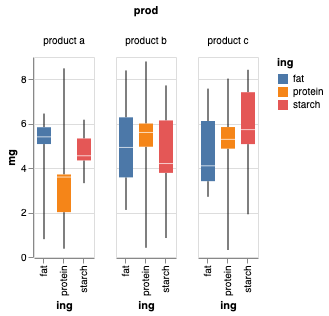

In [133]:
df50 = load_input_table("050.json")

display(df50)
#print(df50.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "boxplot", "extent": "min-max"},
  "encoding": {
    "x": {"field": "ing", "type": "nominal"},
    "color": { "field": "ing", "type": "nominal" },
    "y": { "field": "mg", "type": "quantitative" },
    "column": { "field": "prod", "type": "nominal" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df50)

Feature,Condition,Sex,A,Aneg,p
0,1,F,2,5,7
1,1,M,6,1,7
2,2,F,3,6,9
3,2,M,4,2,6
4,3,F,4,9,13
5,3,M,10,6,16


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "x": {
            "field": "Condition",
            "type": "nominal"
        },
        "color": {
            "field": "Condition",
            "type": "nominal"
        },
        "y": {
            "field": "p",
            "type": "quantitative"
        },
        "column": {
            "field": "Sex",
            "type": "nominal"
        }
    }
}


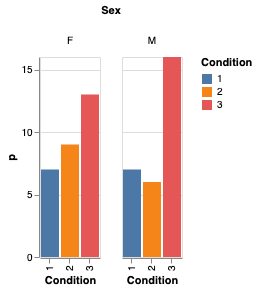

In [134]:
df51 = load_input_table("051.json")

df51 = df51.pivot_table(index=["Condition", "Sex"], columns='Feature', values='value').reset_index()
df51["p"] =  (df51["A"] + df51["Aneg"])

display(df51)

#print(df51.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "bar"},
  "encoding": {
    "x": {"field": "Condition", "type": "nominal"},
    "color": { "field": "Condition", "type": "nominal" },
    "y": { "field": "p", "type": "quantitative" },
    "column": { "field": "Sex", "type": "nominal" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df51)

,Car,Country,Value
0,Audi A6,US,23
1,Audi A6,UK,12
2,Audi A6,DE,19
3,BMW X5,UK,8
4,BMW X5,DE,5


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "x": {
            "field": "Country",
            "type": "nominal"
        },
        "color": {
            "field": "Country",
            "type": "nominal"
        },
        "y": {
            "field": "Value",
            "type": "quantitative"
        },
        "column": {
            "field": "Car",
            "type": "nominal"
        }
    }
}


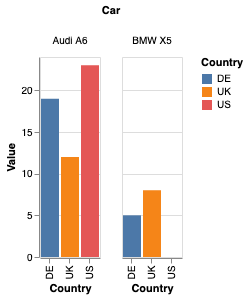

In [135]:
df52 = load_input_table("052.json")
#no transformation

display(df52)

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "bar"},
  "encoding": {
    "x": {"field": "Country", "type": "nominal"},
    "color": { "field": "Country", "type": "nominal" },
    "y": { "field": "Value", "type": "quantitative" },
    "column": { "field": "Car", "type": "nominal" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df52)

,classes,date,score
0,english,9/1/11,1
1,english,9/2/11,1
2,english,9/5/11,2
3,french,9/1/11,2
4,french,9/2/11,1
5,french,9/5/11,1
6,spanish,9/1/11,1
7,spanish,9/3/11,2
8,spanish,9/5/11,1


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "y": {
            "field": "date",
            "type": "nominal"
        },
        "color": {
            "field": "classes",
            "type": "nominal"
        },
        "x": {
            "field": "score",
            "type": "quantitative"
        }
    }
}


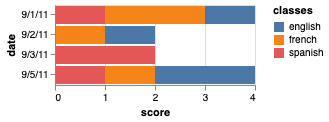

In [136]:
df53 = load_input_table("053.json")
#no transformation

df53 = df53.groupby(['classes', 'date']).count().reset_index()

display(df53)
#print(df53.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "bar"},
  "encoding": {
    "y": {"field": "date", "type": "nominal"},
    "color": { "field": "classes", "type": "nominal" },
    "x": { "field": "score", "type": "quantitative" },
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df53)

,ACH_DATE,MEASURE,NAME,VALUE
0,2017-09-01,DIAG_RATE_65_PLUS,WEST YORKSHIRE,73.6
1,2017-09-01,DIAG_RATE_65_PLUS_LL,WEST YORKSHIRE,66.2
2,2017-09-01,DIAG_RATE_65_PLUS_UL,WEST YORKSHIRE,79.8
3,2017-10-01,DIAG_RATE_65_PLUS,WEST YORKSHIRE,73.7
4,2017-10-01,DIAG_RATE_65_PLUS_LL,WEST YORKSHIRE,66.3
...,...,...,...,...
7,2017-09-01,DIAG_RATE_65_PLUS_LL,NOTTINGHAMSHIRE,69.1
8,2017-09-01,DIAG_RATE_65_PLUS_UL,NOTTINGHAMSHIRE,83.6
9,2017-10-01,DIAG_RATE_65_PLUS,NOTTINGHAMSHIRE,77.5
10,2017-10-01,DIAG_RATE_65_PLUS_LL,NOTTINGHAMSHIRE,69.6


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "errorbar"
    },
    "encoding": {
        "y": {
            "field": "VALUE",
            "type": "quantitative"
        },
        "x": {
            "field": "ACH_DATE",
            "type": "nominal"
        }
    }
}


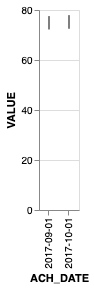

In [137]:
df54 = load_input_table("054.json")
#no transformation

display(df54)

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "errorbar"},
  "encoding": {
    "y": {"field": "VALUE", "type": "quantitative"},
    "x": { "field": "ACH_DATE", "type": "nominal" },
    #"color": { "field": "MEASURE", "type": "nominal" },
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df54)

   group_measure id  value
0            a_c  A      2
1            a_c  B      2
2            a_c  C      3
3            a_c  D      5
4            b_c  A      2
..           ... ..    ...
11           a_d  D      1
12           b_d  A      4
13           b_d  B      2
14           b_d  C      4
15           b_d  D      3

[16 rows x 3 columns]


val1,id,val2,a,b
0,A,c,2,2
1,A,d,4,4
2,B,c,2,5
3,B,d,1,2
4,C,c,3,5
5,C,d,2,4
6,D,c,5,4
7,D,d,1,3


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "point"
    },
    "encoding": {
        "y": {
            "field": "a",
            "type": "quantitative"
        },
        "x": {
            "field": "b",
            "type": "quantitative"
        },
        "column": {
            "field": "val2",
            "type": "nominal"
        }
    }
}


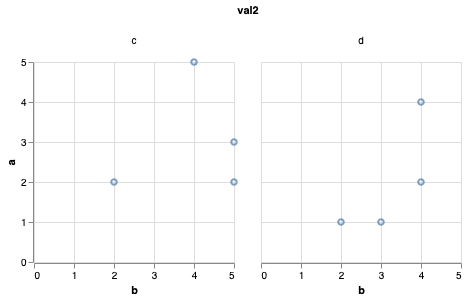

In [138]:
df55 = load_input_table("055.json")

print(df55)

splits = pd.DataFrame(df55["group_measure"].str.split('_', 1).tolist(), columns = ['val1',"val2"])
df55 = pd.concat([df55, splits], axis=1).reset_index()
df55 = df55.pivot_table(index=["id", "val2"], columns='val1', values='value').reset_index()

display(df55)
#print(df55.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "point"},
  "encoding": {
    "y": {"field": "a", "type": "quantitative"},
    "x": { "field": "b", "type": "quantitative" },
    "column": { "field": "val2", "type": "nominal" },
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df55)

,grp,time,variable,value
0,A,1,02,36034
1,B,1,02,63763
2,C,1,02,51432
3,D,1,02,65100
4,E,1,02,61444
...,...,...,...,...
175,B,12,11,100707
176,C,12,11,53324
177,D,12,11,63296
178,E,12,11,24867


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "rect"
    },
    "encoding": {
        "y": {
            "field": "variable",
            "type": "nominal"
        },
        "x": {
            "field": "grp",
            "type": "nominal"
        },
        "column": {
            "field": "time",
            "type": "nominal"
        },
        "color": {
            "field": "value",
            "type": "quantitative"
        }
    }
}


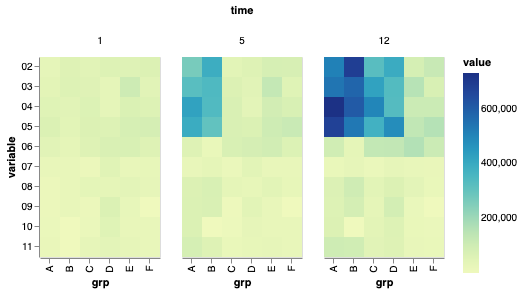

In [140]:
df56 = load_input_table("056.json")

#print(df56)
df56 = pd.melt(df56, id_vars=["grp", "time"], value_vars=["02", "03", "04", "05", "06", "07", "08", "09", "10", "11"])

display(df56)

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "rect"},
  "encoding": {
    "y": {"field": "variable", "type": "nominal"},
    "x": { "field": "grp", "type": "nominal" },
    "column": { "field": "time", "type": "nominal" },
    "color": { "field": "value", "type": "quantitative" },
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df56)

#print(json.dumps(wrap_vl_json(spec, df56)))

axis,group,g,x,y
0,1,0,10.0,8.04
1,1,1,8.0,6.95
2,1,2,13.0,7.58
3,1,3,9.0,8.81
4,1,4,11.0,8.33
...,...,...,...,...
39,4,6,8.0,5.25
40,4,7,19.0,12.50
41,4,8,8.0,5.56
42,4,9,8.0,7.91


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "point"
    },
    "encoding": {
        "x": {
            "field": "x",
            "type": "quantitative"
        },
        "y": {
            "field": "y",
            "type": "quantitative"
        },
        "column": {
            "field": "group",
            "type": "nominal"
        }
    }
}


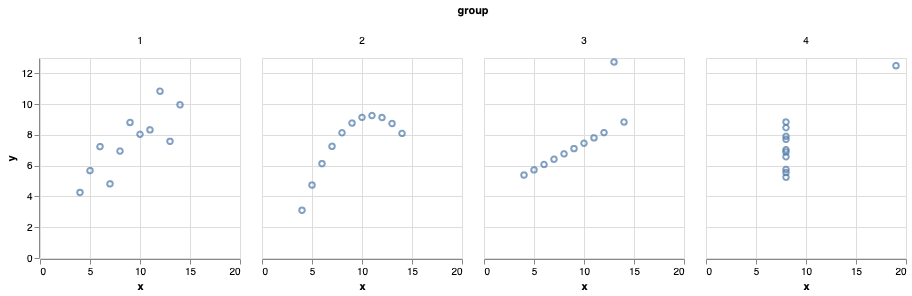

In [142]:
df57 = load_input_table("057.json")

#print(df57)
df57 = pd.melt(df57, id_vars=[], value_vars=["x_1", "x_2", "x_3", "x_4", "y_1", "y_2", "y_3", "y_4"])
splits = pd.DataFrame(df57["variable"].str.split('_', 1).tolist(), columns = ['axis','group'])
df57 = pd.concat([df57, splits], axis=1).reset_index()
df57['g'] = df57.groupby(['axis', "group"])['axis'].cumcount()
df57 = df57.pivot_table(index=["group", "g"], columns='axis', values='value').reset_index()

display(df57)

#print(df57.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "point"},
  "encoding": {
    "x": {"field": "x", "type": "quantitative"},
    "y": { "field": "y", "type": "quantitative" },
    "column": { "field": "group", "type": "nominal" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df57)

,count,date,retailer,type
0,12,04/17/2018,Retailer1,Completed
1,13,04/17/2018,Retailer1,Missed
2,10,04/17/2018,Retailer2,Completed
3,10,04/19/2018,Retailer1,Completed
4,1,04/19/2018,Retailer1,Missed
...,...,...,...,...
7,2,04/21/2018,Retailer1,Completed
8,1,04/21/2018,Retailer2,Completed
9,1,04/21/2018,Retailer1,Missed
10,2,04/23/2018,Retailer1,Completed


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "bar"
    },
    "encoding": {
        "x": {
            "field": "count",
            "type": "quantitative"
        },
        "y": {
            "field": "date",
            "type": "nominal"
        },
        "column": {
            "field": "retailer",
            "type": "nominal"
        },
        "color": {
            "field": "type",
            "type": "nominal"
        }
    }
}


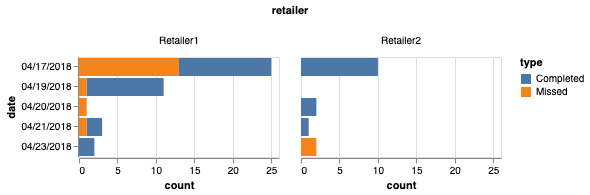

In [143]:
df58 = load_input_table("058.json")
# no transformation

display(df58)
#print(df58.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "bar"},
  "encoding": {
    "x": {"field": "count", "type": "quantitative"},
    "y": { "field": "date", "type": "nominal" },
    "column": { "field": "retailer", "type": "nominal" },
    "color": { "field": "type", "type": "nominal" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df58)

group,ID,time,g1,g2
0,1,0min,1,10
1,1,10min,4,13
2,1,30min,7,16
3,2,0min,2,11
4,2,10min,5,14
5,2,30min,8,17
6,3,0min,3,12
7,3,10min,6,15
8,3,30min,9,18


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "point"
    },
    "encoding": {
        "x": {
            "field": "g1",
            "type": "quantitative"
        },
        "y": {
            "field": "g2",
            "type": "quantitative"
        },
        "column": {
            "field": "ID",
            "type": "nominal"
        }
    }
}


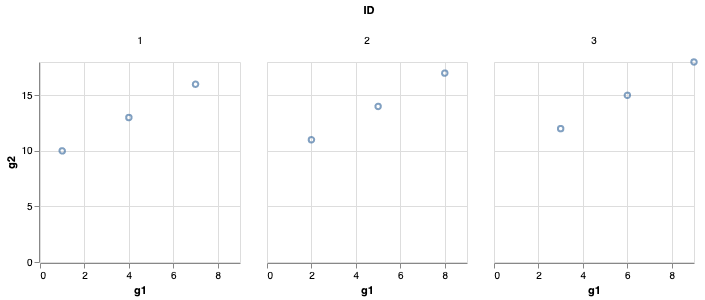

In [144]:
df59 = load_input_table("059.json")

df59 = pd.melt(df59, id_vars=["name", "ID"], 
                value_vars=["persons_g1_0min", "persons_g1_10min", 
                            "persons_g1_30min", "persons_g2_0min", 
                            "persons_g2_10min", "persons_g2_30min"])

splits = pd.DataFrame(df59["variable"].str.split('_', 2).tolist(), columns = ['v1','group', "time"])
df59 = pd.concat([df59, splits], axis=1).reset_index()
df59 = df59.pivot_table(index=["ID", "time"], columns='group', values='value').reset_index()

display(df59)

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "point"},
  "encoding": {
    "x": {"field": "g1", "type": "quantitative"},
    "y": { "field": "g2", "type": "quantitative" },
    "column": { "field": "ID", "type": "nominal" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df59)

fac,g,trial1,trial2
0,0,1.0355,1.7138
1,1,1.4998,2.6099
2,2,2.1847,4.3185
3,3,1.0140,2.8532
4,4,1.8388,3.2195
5,5,1.3549,4.4374
6,6,0.9128,2.1362
7,7,1.6856,2.5519
8,8,3.0877,1.2056
9,9,3.2488,2.6400


{
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {
        "type": "line"
    },
    "encoding": {
        "x": {
            "field": "trial2",
            "type": "quantitative"
        },
        "y": {
            "field": "trial1",
            "type": "quantitative"
        }
    }
}


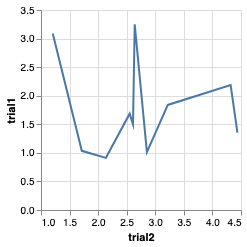

In [145]:
df60 = load_input_table("060.json")

df60['g'] = df60.groupby(['fac'])['score'].cumcount()
df60 = df60.pivot_table(index=["g"], columns='fac', values='score').reset_index()

display(df60)
#print(df60.to_json(orient="records"))

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": { "type": "line"},
  "encoding": {
    "x": {"field": "trial2", "type": "quantitative"},
    "y": { "field": "trial1", "type": "quantitative" }
  }
}

print(json.dumps(spec, indent=4))

VegaLite(spec, df60)